# Evaluating Sharpness Preservation

Get 10% and 50% MTFs for fbp, red-cnn, and red-cnn augmentation

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
phantom_dir = base_dir / 'CTP404_peds'
meta = pd.read_csv(phantom_dir / 'metadata.csv')
meta

Name phantom  effective diameter [cm]  FOV [cm]  \
0    35.0 mm CTP404  CTP404                     35.0      38.5   
1    35.0 mm CTP404  CTP404                     35.0      38.5   
2    35.0 mm CTP404  CTP404                     35.0      38.5   
3    35.0 mm CTP404  CTP404                     35.0      38.5   
4    35.0 mm CTP404  CTP404                     35.0      38.5   
..              ...     ...                      ...       ...   
187  15.1 mm CTP404  CTP404                     15.1      16.6   
188  15.1 mm CTP404  CTP404                     15.1      16.6   
189  15.1 mm CTP404  CTP404                     15.1      16.6   
190  15.1 mm CTP404  CTP404                     15.1      16.6   
191  15.1 mm CTP404  CTP404                     15.1      16.6   

                 recon  Dose [%]  \
0    RED-CNN augmented        10   
1              RED-CNN        10   
2                  fbp        10   
3    RED-CNN augmented        40   
4              RED-CNN        40   
..                 ...       ...   
187            RED-CNN        70   
188                fbp        70   
189  RED-CNN augmented        85   
190            RED-CNN        85   
191                fbp        85   

                                                  file  simulated kernel  \
0    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
1    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
2    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
3    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
4    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
..                                                 ...        ...    ...   
187  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
188  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
189  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
190  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
191  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   

                        scanner  
0    Siemens Somatom Definition  
1    Siemens Somatom Definition  
2    Siemens Somatom Definition  
3    Siemens Somatom Definition  
4    Siemens Somatom Definition  
..                          ...  
187  Siemens Somatom Definition  
188  Siemens Somatom Definition  
189  Siemens Somatom Definition  
190  Siemens Somatom Definition  
191  Siemens Somatom Definition  

[192 rows x 10 columns]

1. move the CTP404 phantom simulations from `/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404` to `/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds` - **done**
2. add metaheaders to make them easier to load, with pixel size and recon info? -> dicom eventually for this last one - **done**
3. make metadata csv like for CCT189 - **done**

4. make sure Ct numbers have 0 offset, so air == -1000, water == 0 - **done**
5. run denoisers on the CTP dataset - **done**
6. then run /home/brandon.nelson/Dev/DLIR_Ped_Generalizability/geometric_phantom_studies/evaluation/MTF

In [5]:
import SimpleITK as sitk
vol = sitk.ReadImage(meta.file[0])
vol.GetDepth(), vol.GetWidth(), vol.GetHeight()

(20, 512, 512)

In [6]:
meta[(meta['Dose [%]']==25)&
     (meta['effective diameter [cm]']==35)&
     (meta['FOV [cm]']==38.5)]

Name phantom  effective diameter [cm]  FOV [cm]  \
9   35.0 mm CTP404  CTP404                     35.0      38.5   
10  35.0 mm CTP404  CTP404                     35.0      38.5   
11  35.0 mm CTP404  CTP404                     35.0      38.5   

                recon  Dose [%]  \
9   RED-CNN augmented        25   
10            RED-CNN        25   
11                fbp        25   

                                                 file  simulated kernel  \
9   /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
10  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
11  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   

                       scanner  
9   Siemens Somatom Definition  
10  Siemens Somatom Definition  
11  Siemens Somatom Definition

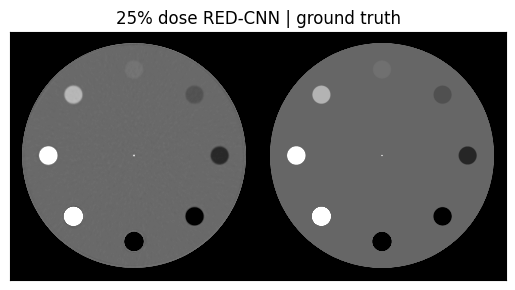

In [7]:
from results_utils import browse_studies, study_viewer
browse_studies(meta, phantom='CTP404', diameter=35, fov=38.5, dose=25, recon='RED-CNN')

In [8]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('CTP404',), value='CTP404'), Dropdown(descripti…

## Measuring MTF

### Selecting HU-Specific ROIs

In [9]:
from utils import get_ground_truth, load_mhd
import SimpleITK as sitk
row = meta[(meta['Dose [%]']==1000)&(meta['effective diameter [cm]']==35)].iloc[0]
file = row.file

gt_file = get_ground_truth(file)
file, gt_file

('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter350mm/dose_1000/RED-CNN augmented/350mm_dose_1000_RED-CNN augmented.mhd',
 PosixPath('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter350mm/true.mhd'))

In [10]:
img = load_mhd(file)
gt_img = load_mhd(gt_file)

In [11]:
contrast_locations = pd.read_csv('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404/monochromatic/diameter350mm/phantom_info_pix_idx.csv')
contrast_locations.rename(columns=dict(zip(contrast_locations.columns, list(map(lambda o: o.strip(), contrast_locations.columns)))), inplace=True)
water_attenuation_coefficient = contrast_locations[contrast_locations['x radius'] == contrast_locations['x radius'].max()]['mu [60 keV]'].item()
contrast_locations['Contrast [HU]'] = round((contrast_locations['mu [60 keV]'])/water_attenuation_coefficient*1000)
contrast_locations.loc[contrast_locations['mu [60 keV]']==water_attenuation_coefficient, 'Contrast [HU]'] = 0 
contrast_locations

x center  y center   x radius   y radius  angle degree  mu [60 keV]  \
0       256       256  232.73000  232.73000             0     0.020590   
1       256       433   18.61800   18.61800             0     0.000309   
2       381       381   18.61800   18.61800             0    -0.000721   
3       433       256   18.61800   18.61800             0    -0.002059   
4       381       131   18.61800   18.61800             0    -0.004118   
5       256        79   18.61800   18.61800             0    -0.020590   
6       131       131   18.61800   18.61800             0     0.020384   
7        79       256   18.61800   18.61800             0     0.007001   
8       131       381   18.61800   18.61800             0     0.002471   
9       256       256    0.33247    0.33247             0     0.123540   

   Contrast [HU]  
0            0.0  
1           15.0  
2          -35.0  
3         -100.0  
4         -200.0  
5        -1000.0  
6          990.0  
7          340.0  
8          120.0  
9         6000.0

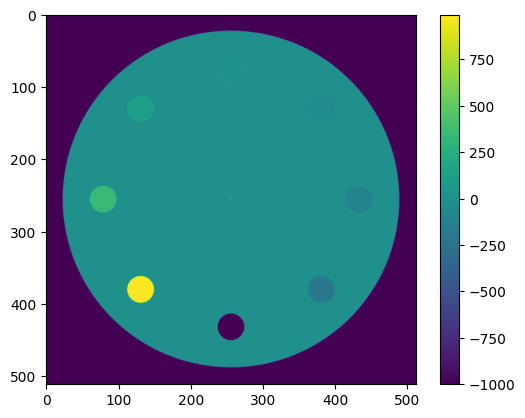

In [12]:
plt.imshow(gt_img)
plt.colorbar()

In [13]:
np.unique(gt_img), len(np.unique(gt_img))

(array([-1000,  -937,  -875,  -812,  -750,  -688,  -687,  -625,  -562,
         -500,  -437,  -375,  -312,  -250,  -200,  -187,  -175,  -163,
         -150,  -137,  -125,  -113,  -100,   -94,   -87,   -81,   -75,
          -69,   -63,   -62,   -56,   -50,   -44,   -38,   -37,   -35,
          -33,   -31,   -28,   -26,   -25,   -24,   -22,   -20,   -19,
          -18,   -17,   -15,   -13,   -12,   -11,    -9,    -6,    -4,
           -2,     0,     1,     2,     3,     4,     5,     6,     7,
            8,     9,    10,    11,    12,    13,    14,    15,    21,
           30,    38,    43,    45,    53,    60,    62,    64,    68,
           75,    83,    85,    90,    98,   105,   106,   113,   120,
          124,   128,   149,   170,   191,   213,   234,   247,   248,
          255,   276,   298,   309,   319,   340,   371,   375,   433,
          495,   557,   619,   681,   742,   743,   804,   866,   928,
          990], dtype=int16),
 118)

There should be no more than 10 unique values in the ground truth image (8 inserts + background + foreground)

In [14]:
row

Name                                                          35.0 mm CTP404
phantom                                                               CTP404
effective diameter [cm]                                                 35.0
FOV [cm]                                                                38.5
recon                                                      RED-CNN augmented
Dose [%]                                                                1000
file                       /gpfs_projects/brandon.nelson/PediatricCTSizeD...
simulated                                                               True
kernel                                                                   D45
scanner                                           Siemens Somatom Definition
Name: 6, dtype: object

88.41670439112721


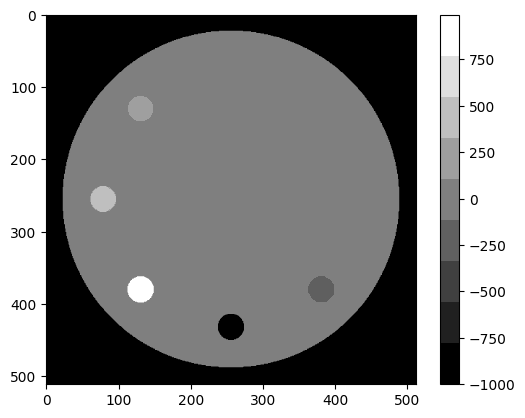

In [15]:
from skimage import measure
def deblur_ground_truth(gt_img, size_thresh=1000):
    label_image = measure.label(gt_img, background=-1000)
    mask = np.zeros_like(label_image)
    for label in np.unique(label_image):
        if (np.sum(label_image==label) < size_thresh): continue
        mask[label_image==label]=gt_img[label_image==label]
    return mask

pixel_size_mm = sitk.ReadImage(file).GetSpacing()[0]
min_area_mm2 = 50
size_thresh_pixels = min_area_mm2/(pixel_size_mm**2)
print(size_thresh_pixels)
gt_img = load_mhd(gt_file)
gt_img = deblur_ground_truth(gt_img, size_thresh=min_area_mm2/(pixel_size_mm**2))
plt.imshow(gt_img, cmap=plt.get_cmap('gray', len(np.unique(gt_img))))
plt.colorbar()

In [16]:
np.unique(gt_img), len(np.unique(gt_img))

(array([-1000,  -200,  -100,   -35,     0,    15,   120,   340,   990]), 9)

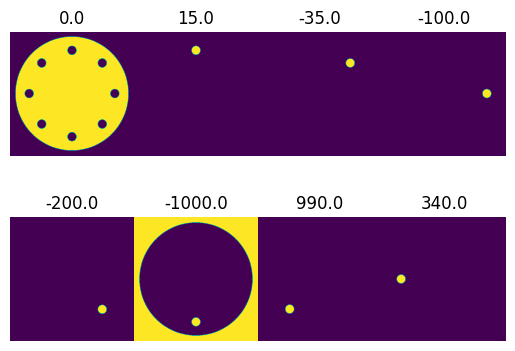

In [17]:
from skimage import data, util, measure
f, axs = plt.subplots(2,4, sharex=True, sharey=True, gridspec_kw=dict(hspace=0, wspace=0))
for ax, HU in zip(axs.flatten(), contrast_locations['Contrast [HU]']):
    ax.imshow(gt_img==HU) #label = 0 is background, 1 is the largest object
    ax.set_title(HU)
    ax.axis('off')

Now add radial averaging... and loop through all contrasts and do this for all recons to get ESF --> MTF --> MTF10, MTF50

In [18]:
import numpy as np

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def get_radial_coords(img, center, radius, angle, num=None):
    if num is None:
        num = np.ceil(radius).astype(int)
    coords = np.round(np.array(list(map(lambda r: pol2cart(r, phi=angle), np.linspace(0, radius, num=num))))+center).astype(int)
    return coords

def radial_profile(img, center, radius, angle, num=None):
    coords = get_radial_coords(img, center, radius, angle, num)
    return [img[x,y] for x, y in coords]

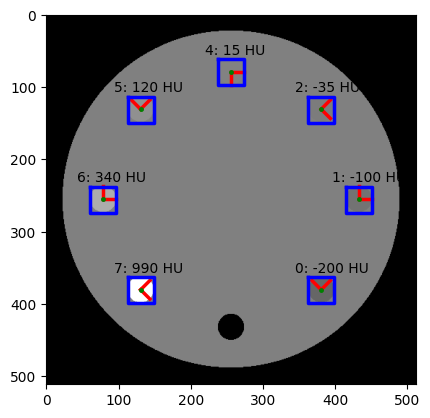

In [19]:
import math

regions = measure.regionprops(gt_img+1000)

fig, ax = plt.subplots()
ax.imshow(gt_img, cmap=plt.cm.gray)
for idx, props in enumerate(regions):
    if (props.label - 1000) == 0:
        continue
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=5)
    ax.annotate(f'{idx}: {props.label-1000} HU', (x0-props.axis_major_length, y0-props.axis_major_length/1.5))

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
plt.show()

In [20]:
45+180

225

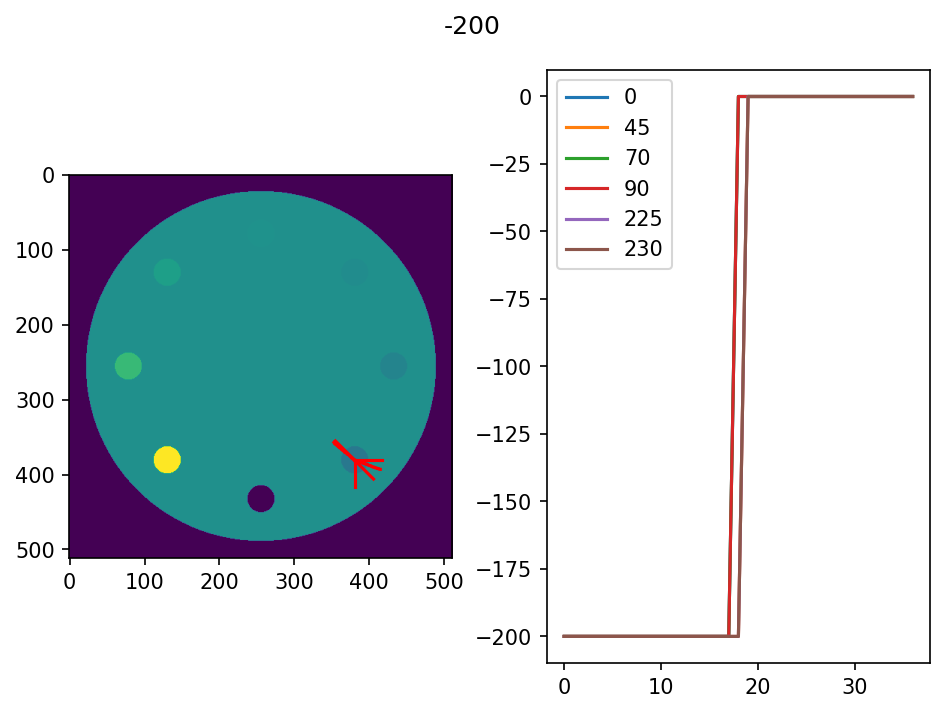

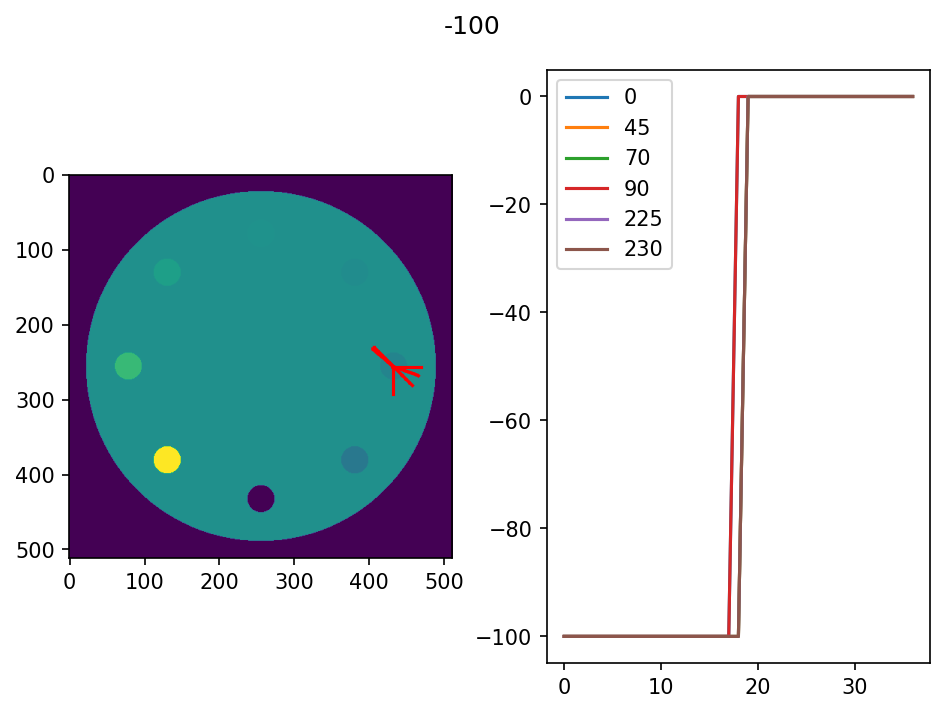

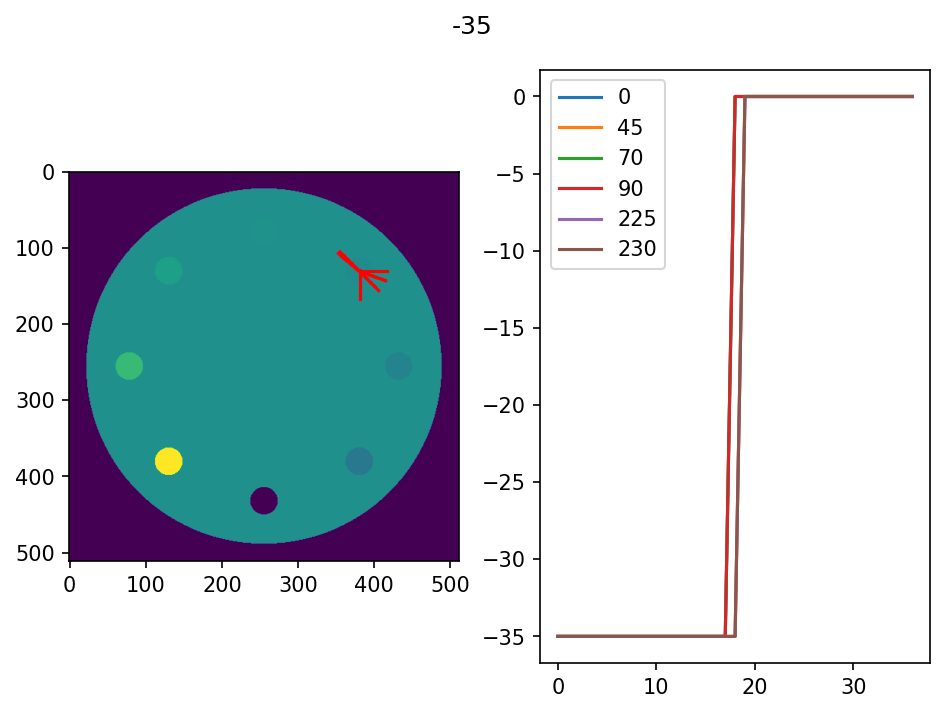

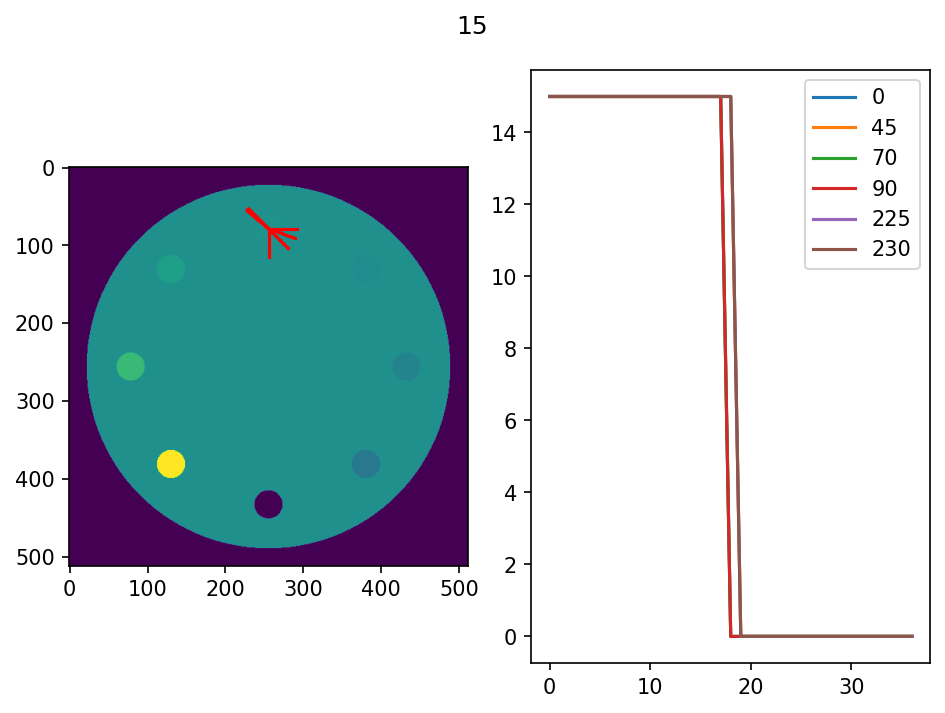

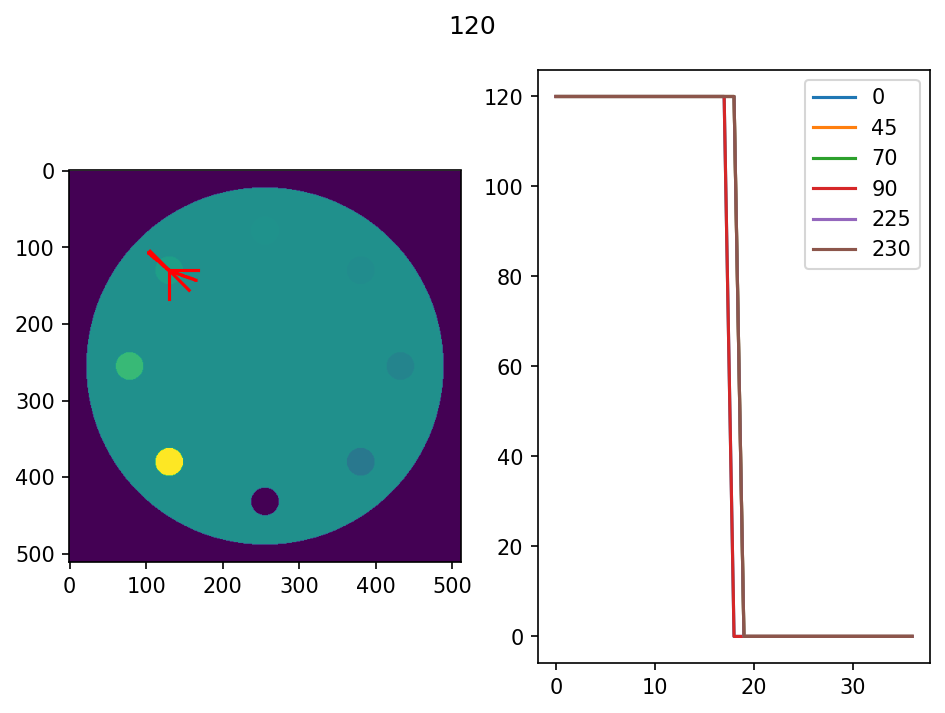

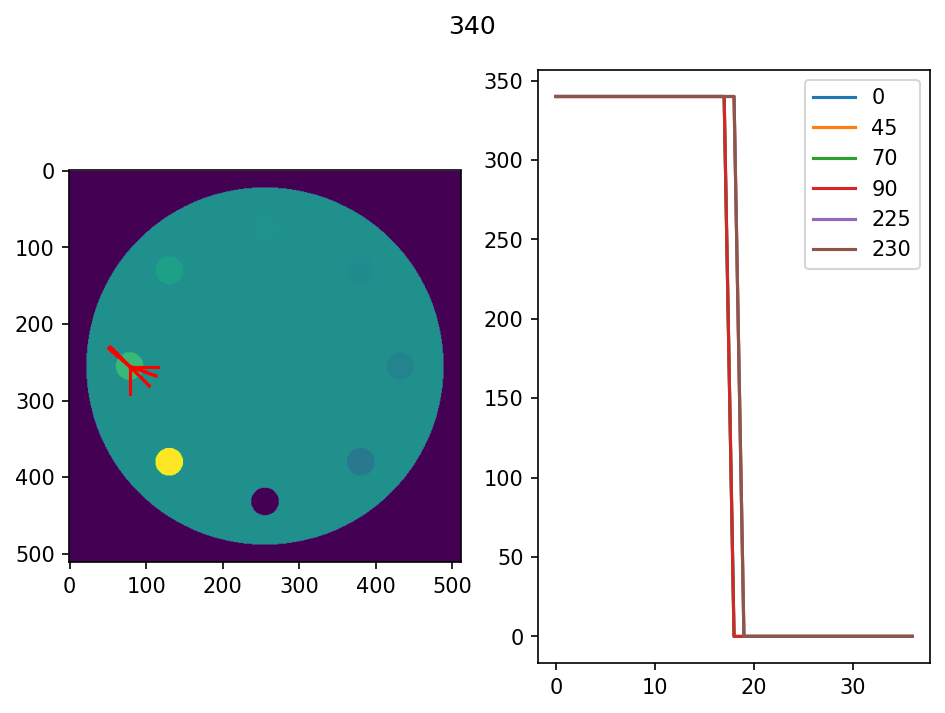

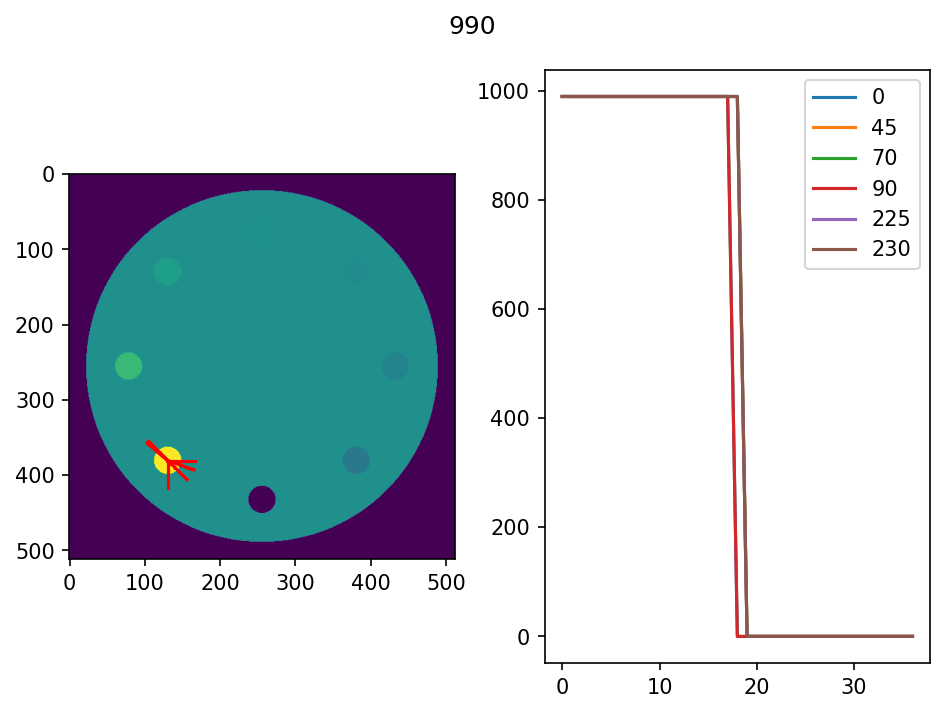

In [21]:
for region in regions:
    contrast = region.label-1000
    if contrast == 0: continue
    f, axs = plt.subplots(1, 2, tight_layout=True, dpi=150)

    for deg in [0, 45, 70, 90, 225, 230]:
        center = region.centroid
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        coords = get_radial_coords(gt_img, center, 2*radius, np.deg2rad(deg))
        axs[0].imshow(gt_img)
        axs[0].plot(coords[:, 1], coords[:, 0], color='red', label=deg)

        axs[1].plot(gt_img.flat[np.ravel_multi_index(coords.T, gt_img.shape)], label=deg)
    axs[1].legend()
    f.suptitle(f'{contrast}')
    plt.show()

In [22]:
measured_centers = {r.label-1000:np.array(r.centroid).round() for r in regions}
measured_centers

{-200: array([381., 381.]),
 -100: array([256., 432.]),
 -35: array([130., 381.]),
 0: array([256., 256.]),
 15: array([ 79., 256.]),
 120: array([130., 130.]),
 340: array([256.,  79.]),
 990: array([381., 130.])}

In [23]:
true_centers = {c: contrast_locations.loc[contrast_locations['Contrast [HU]']==c, ['x center', 'y center']].to_numpy().T.squeeze() for c in measured_centers}
true_centers

{-200: array([381, 131]),
 -100: array([433, 256]),
 -35: array([381, 381]),
 0: array([256, 256]),
 15: array([256, 433]),
 120: array([131, 381]),
 340: array([ 79, 256]),
 990: array([131, 131])}

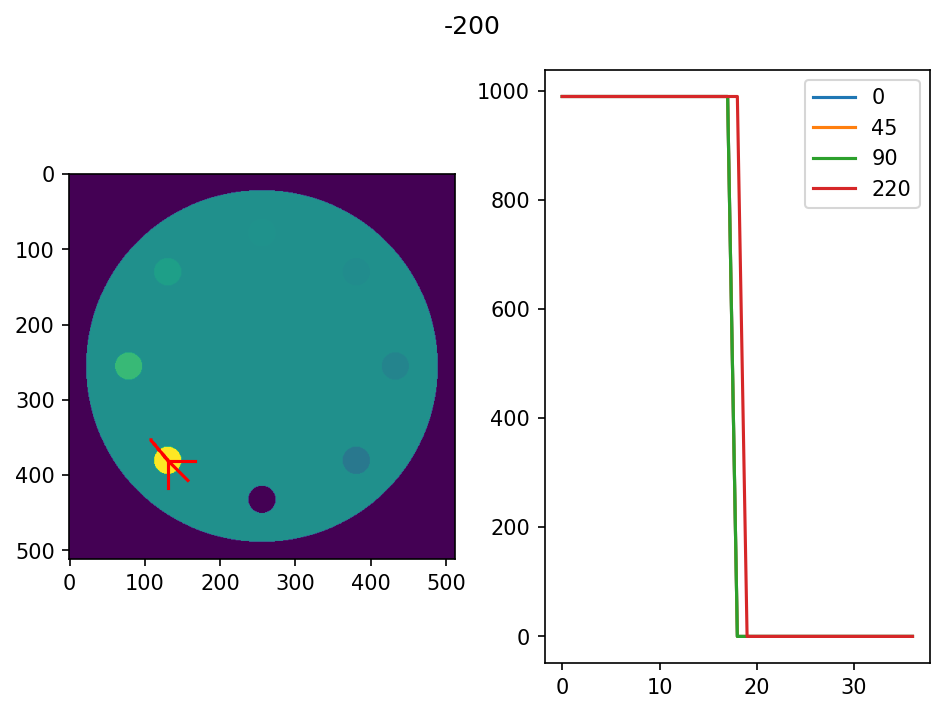

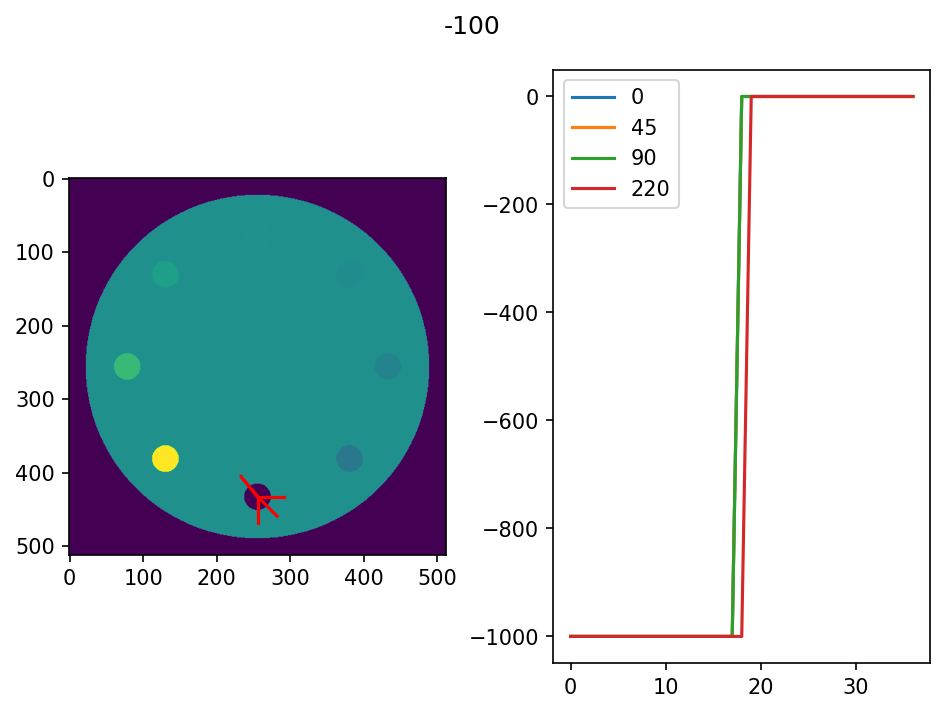

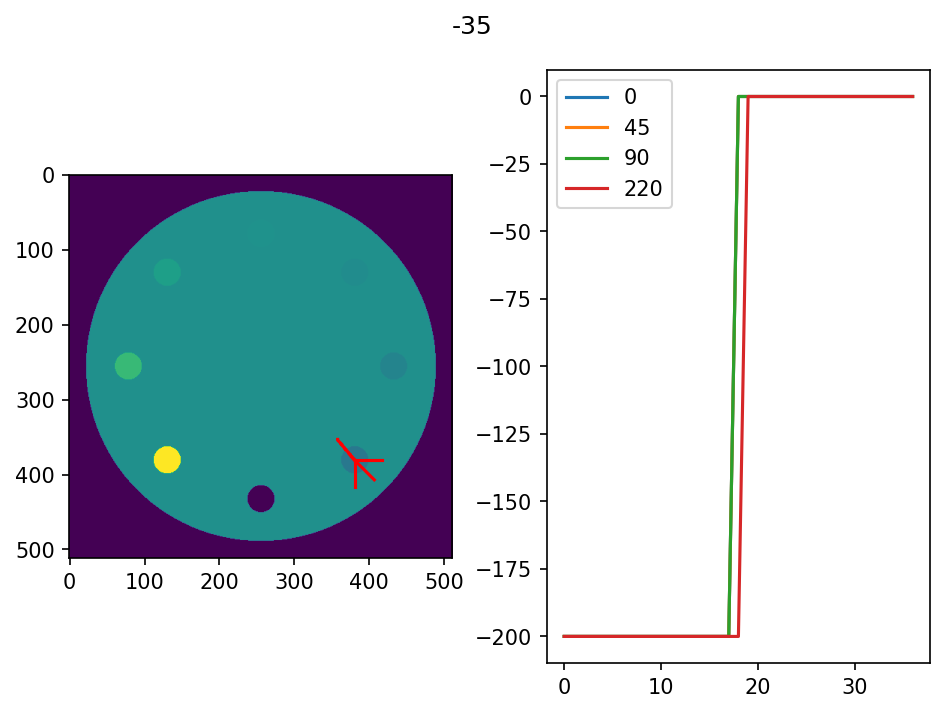

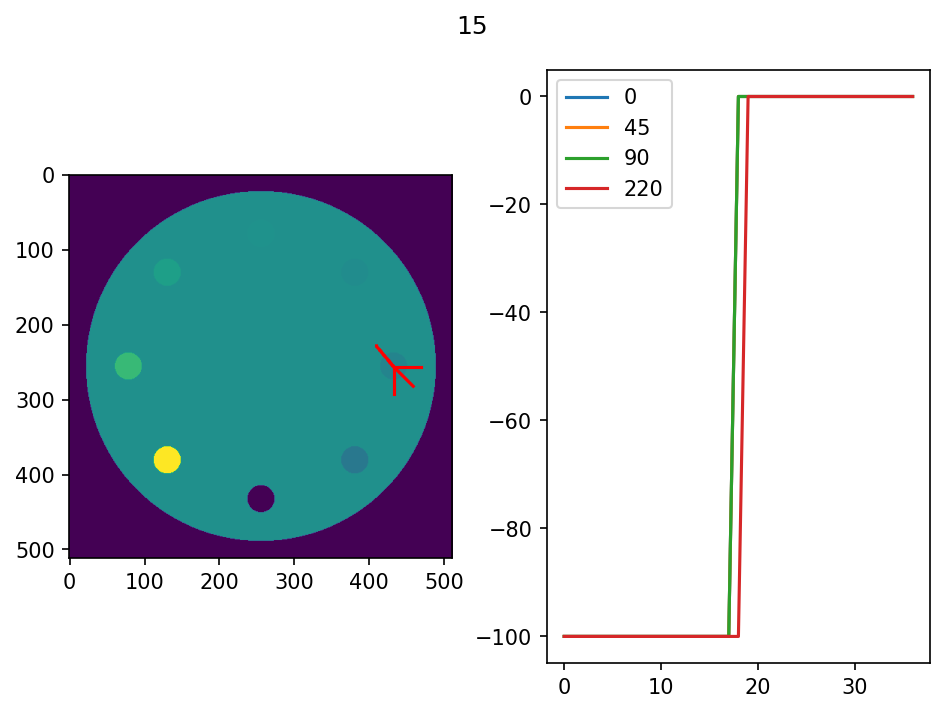

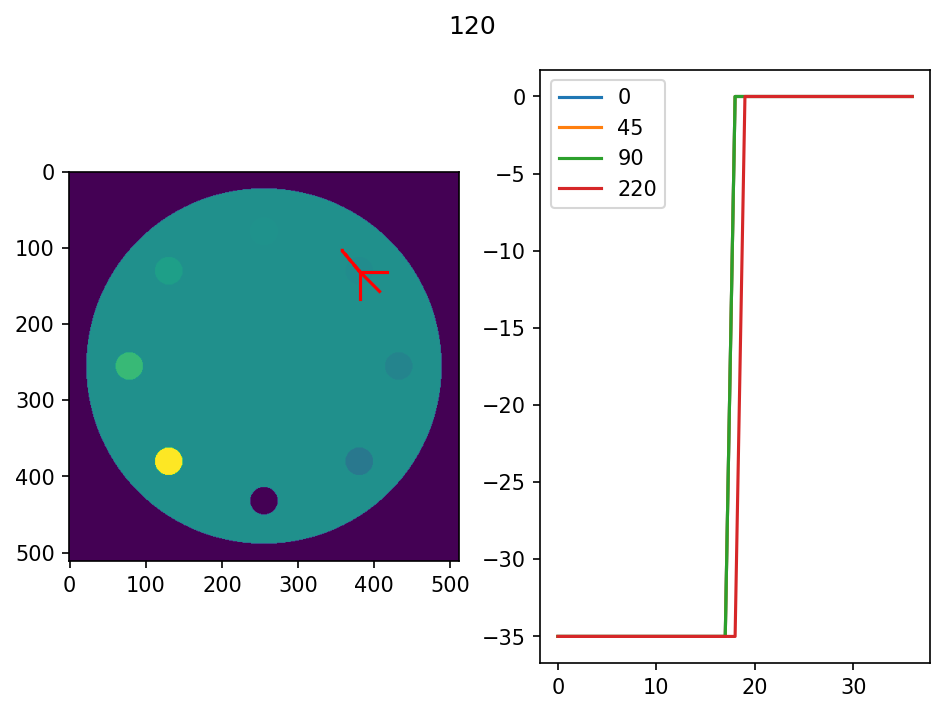

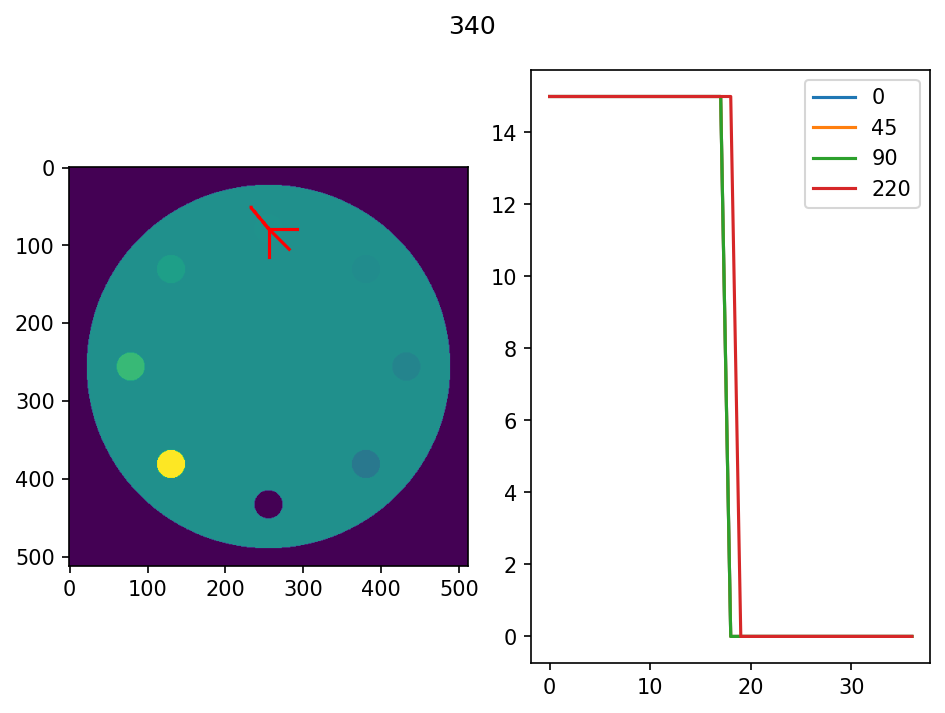

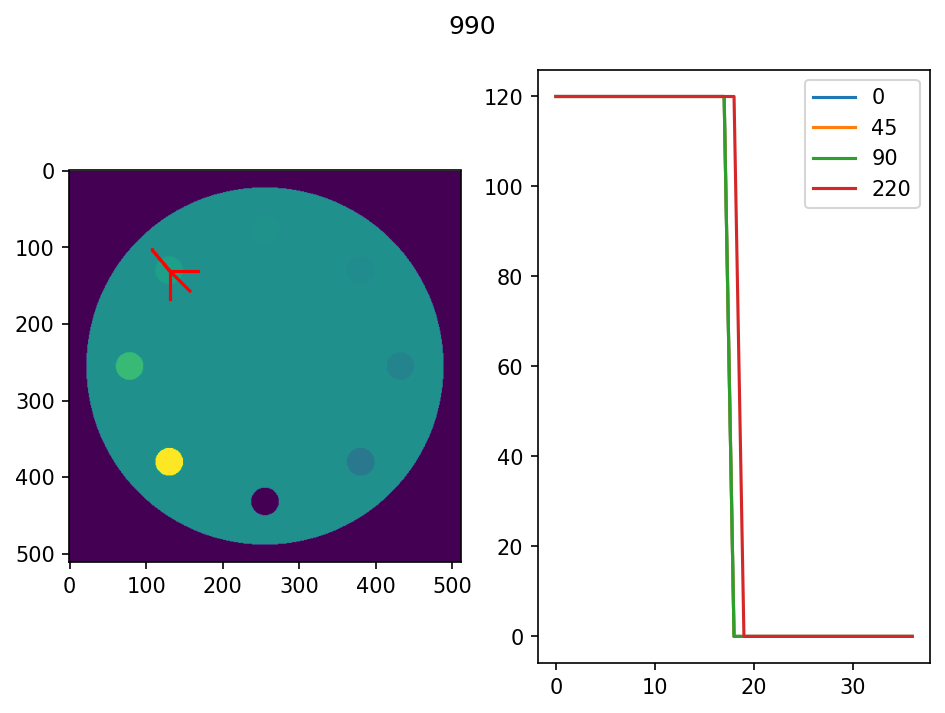

In [24]:
for region in regions:
    contrast = region.label-1000
    if contrast == 0: continue
    f, axs = plt.subplots(1, 2, tight_layout=True, dpi=150)

    for deg in [0, 45, 90, 220]:
        # center = region.centroid
        center = true_centers[contrast]
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        coords = get_radial_coords(gt_img, center, 2*radius, np.deg2rad(deg))
        axs[0].imshow(gt_img)
        axs[0].plot(coords[:, 1], coords[:, 0], color='red', label=deg)

        axs[1].plot(gt_img.flat[np.ravel_multi_index(coords.T, gt_img.shape)], label=deg)
    axs[1].legend()
    f.suptitle(f'{contrast}')
    plt.show()

It seems even with the true center there are still some misalignments due to discrete sampling 

In [25]:
def get_align_profile_shift(p0, ref):
    'aligns p0 to ref'
    p0 = list(p0)
    ref = list(ref)
    shift = np.argmax(abs(np.diff(ref))) - np.argmax(abs(np.diff(p0)))
    return shift

def shift_profile(p0, shift):
    'aligns p0 to ref'
    # print(shift)
    rolled = np.roll(p0, shift)
    if shift > 0:
        rolled[:shift] = p0[0]
        return list(rolled)
    elif shift < 0:
        shift = abs(shift)
        rolled[-shift:] = p0[-1]
        return list(rolled)
    else:
        return p0

for region in regions:
    contrast = region.label-1000
    if contrast == 0: continue
    f, axs = plt.subplots(1, 2, tight_layout=True, dpi=150)

    for deg in [0, 45, 70, 90, 225, 230]:
        center = region.centroid
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        coords = get_radial_coords(gt_img, center, 2*radius, np.deg2rad(deg))
        axs[0].imshow(img[0], cmap='gray')
        axs[0].plot(coords[:, 1], coords[:, 0], color='red', label=deg)

        axs[1].plot(img[0].flat[np.ravel_multi_index(coords.T, gt_img.shape)], label=deg)
    axs[1].legend()
    f.suptitle(f'{contrast}')
    plt.show()

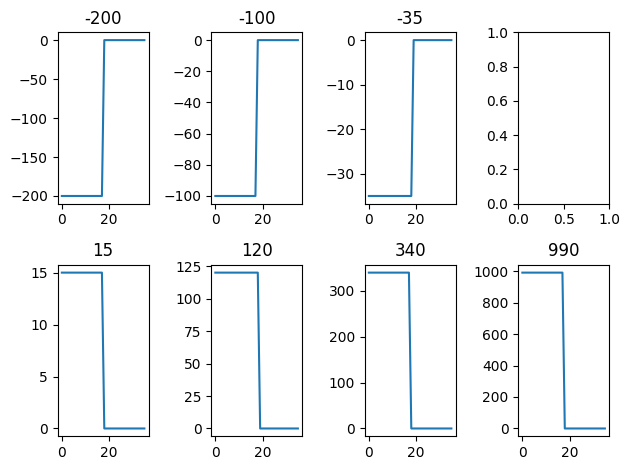

In [26]:
f, axs = plt.subplots(2, 4, tight_layout=True)
for ax, region in zip(axs.flatten(), regions):
    center = region.centroid
    contrast = region.label-1000
    if contrast == 0: continue
    radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
    x0 = round(center[0])
    x1 = int(x0 + 2*radius)
    y0 = round(center[1])
    y1 = int(y0 + 1)
    ax.plot(gt_img[x0:x1, y0:y1])
    ax.set_title(contrast)

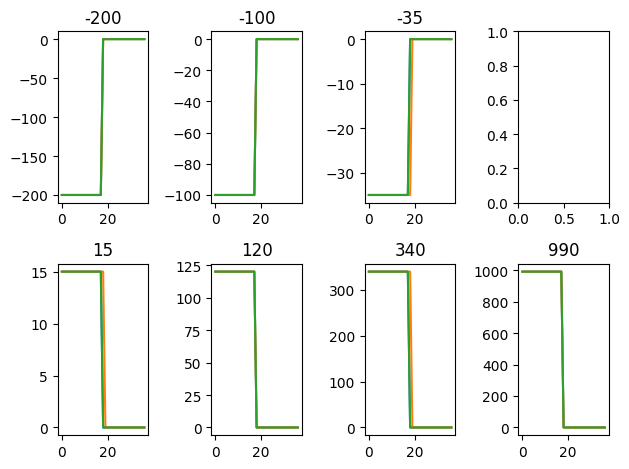

In [27]:
f, axs = plt.subplots(2, 4, tight_layout=True)
for deg in [0, 120, 180]:
    for ax, region in zip(axs.flatten(), regions):
        center = np.array(region.centroid)
        contrast = region.label-1000
        if contrast == 0: continue
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        ax.plot(radial_profile(gt_img, center, 2*radius, angle=np.deg2rad(deg)), label=deg)
        ax.set_title(contrast)
plt.show()

In [28]:
[1, 2, 3] == [1, 2, 2]

False

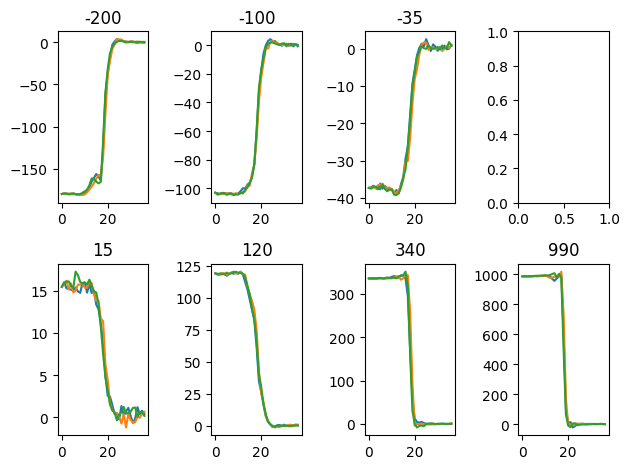

In [29]:
f, axs = plt.subplots(2, 4, tight_layout=True)
for deg in [0, 120, 180]:
    for ax, region in zip(axs.flatten(), regions):
        center = np.array(region.centroid)
        contrast = region.label-1000
        if contrast == 0: continue
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        ax.plot(radial_profile(img[0], center, 2*radius, angle=np.deg2rad(deg)), label=deg)
        ax.set_title(contrast)
plt.show()

In [30]:
get_align_profile_shift?

Signature: get_align_profile_shift(p0, ref)
Docstring: aligns p0 to ref
File:      /tmp/ipykernel_2299463/1385758228.py
Type:      function

In [31]:
import seaborn as sns

def measure_esf(file, nangles=4):
    """
    Measures edqe spread functions at `nangles` equi-radially spaced for each contrast
    """
    distances = []
    profiles = []
    degrees = []
    contrasts = []
    series = []

    img = load_mhd(file)
    gt_img = load_mhd(get_ground_truth(file))
    pixel_size_mm = sitk.ReadImage(file).GetSpacing()[0]
    min_area_mm2 = 50
    size_thresh_pixels = min_area_mm2/(pixel_size_mm**2)
    gt_img = deblur_ground_truth(gt_img, size_thresh=size_thresh_pixels)

    regions = measure.regionprops(gt_img+1000)
    angles = np.linspace(0, 180, nangles)

    for region in regions:
        contrast = region.label - 1000
        if contrast == 0: continue
        center = region.centroid
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        for deg in angles:
            rad = np.deg2rad(deg)
            new_gt_profile = radial_profile(gt_img, center=center, radius=2*radius, angle=rad)
            if rad == 0:
                gt_profile = new_gt_profile.copy()
            img_profile = list(np.mean([radial_profile(repeat, center=center, radius=2*radius, angle=rad) for repeat in img], axis=0))
            idx = 0
            while gt_profile!=new_gt_profile:
                idx += 1
                if idx > 1:
                    raise RuntimeError(f'Could not align edge after {idx} attempts at angle {deg} degrees')
                    # get_align_profile_shift(p0, ref)
                shift = get_align_profile_shift(new_gt_profile, gt_profile)
                new_gt_profile = shift_profile(new_gt_profile, shift)
                img_profile = shift_profile(img_profile, shift)
   
            gt_profile = new_gt_profile
            
            degrees = degrees + len(gt_profile)*[deg] + len(img_profile)*[deg]
            distances = distances + list(range(len(gt_profile))) + list(range(len(img_profile)))
            profiles = profiles + gt_profile + img_profile
            contrasts = contrasts + len(gt_profile)*[contrast] + len(img_profile)*[contrast]
            series =  series + len(gt_profile)*['truth'] + len(img_profile)*['image']
    esf = pd.DataFrame({'series': series,
                        'contrast': contrasts,
                        'angle [degree]': degrees,
                        'distance': distances,
                        'ESF': profiles})
    return esf

file = meta[meta['Dose [%]']==1000].iloc[0].file
esf = measure_esf(file)
esf.head()

series  contrast  angle [degree]  distance    ESF
0  truth      -200             0.0         0 -200.0
1  truth      -200             0.0         1 -200.0
2  truth      -200             0.0         2 -200.0
3  truth      -200             0.0         3 -200.0
4  truth      -200             0.0         4 -200.0

In [32]:
file

'/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter350mm/dose_1000/RED-CNN augmented/350mm_dose_1000_RED-CNN augmented.mhd'

<Axes: xlabel='distance', ylabel='ESF'>

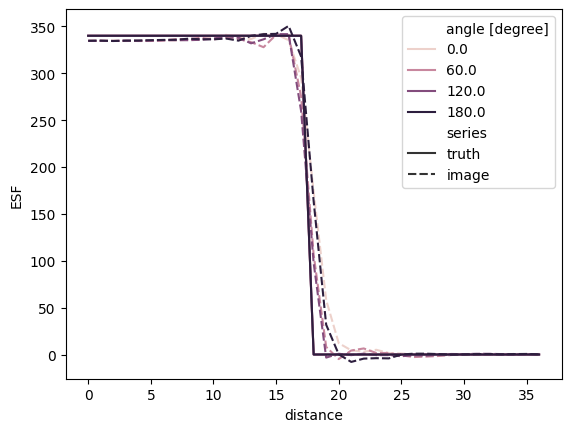

In [33]:
sns.lineplot(data=esf[(esf.contrast==340)], hue='angle [degree]', x='distance', y='ESF', style='series')

In [34]:
from tqdm import tqdm

df_list = []
for idx, row in tqdm(meta[meta['Dose [%]']==1000].iterrows(), total=len(meta)):
    file = row.file
    esf = measure_esf(file)
    esf['effective diameter [cm]']=row['effective diameter [cm]']
    esf['FOV [cm]']=row['FOV [cm]']
    esf['recon']=row['recon']
    esf.loc[esf['series']=='truth', 'recon'] = 'truth'
    esf['Dose [%]']=row['Dose [%]']
    df_list.append(esf)
esf = pd.concat(df_list, ignore_index=True)
esf

 12%|█▎        | 24/192 [00:06<00:46,  3.65it/s]


series  contrast  angle [degree]  distance     ESF  \
0      truth      -200             0.0         0 -200.00   
1      truth      -200             0.0         1 -200.00   
2      truth      -200             0.0         2 -200.00   
3      truth      -200             0.0         3 -200.00   
4      truth      -200             0.0         4 -200.00   
...      ...       ...             ...       ...     ...   
46531  image       990           180.0        32   -0.95   
46532  image       990           180.0        33    0.25   
46533  image       990           180.0        34    0.15   
46534  image       990           180.0        35    0.60   
46535  image       990           180.0        36    0.35   

       effective diameter [cm]  FOV [cm]  recon  Dose [%]  
0                         35.0      38.5  truth      1000  
1                         35.0      38.5  truth      1000  
2                         35.0      38.5  truth      1000  
3                         35.0      38.5  truth      1000  
4                         35.0      38.5  truth      1000  
...                        ...       ...    ...       ...  
46531                     15.1      16.6    fbp      1000  
46532                     15.1      16.6    fbp      1000  
46533                     15.1      16.6    fbp      1000  
46534                     15.1      16.6    fbp      1000  
46535                     15.1      16.6    fbp      1000  

[46536 rows x 9 columns]

In [35]:
measure_esf(file, nangles=3)

series  contrast  angle [degree]  distance     ESF
0     truth      -200             0.0         0 -200.00
1     truth      -200             0.0         1 -200.00
2     truth      -200             0.0         2 -200.00
3     truth      -200             0.0         3 -200.00
4     truth      -200             0.0         4 -200.00
...     ...       ...             ...       ...     ...
1549  image       990           180.0        32   -0.95
1550  image       990           180.0        33    0.25
1551  image       990           180.0        34    0.15
1552  image       990           180.0        35    0.60
1553  image       990           180.0        36    0.35

[1554 rows x 5 columns]

In [36]:
esf.recon.unique()

array(['truth', 'RED-CNN augmented', 'RED-CNN', 'fbp'], dtype=object)

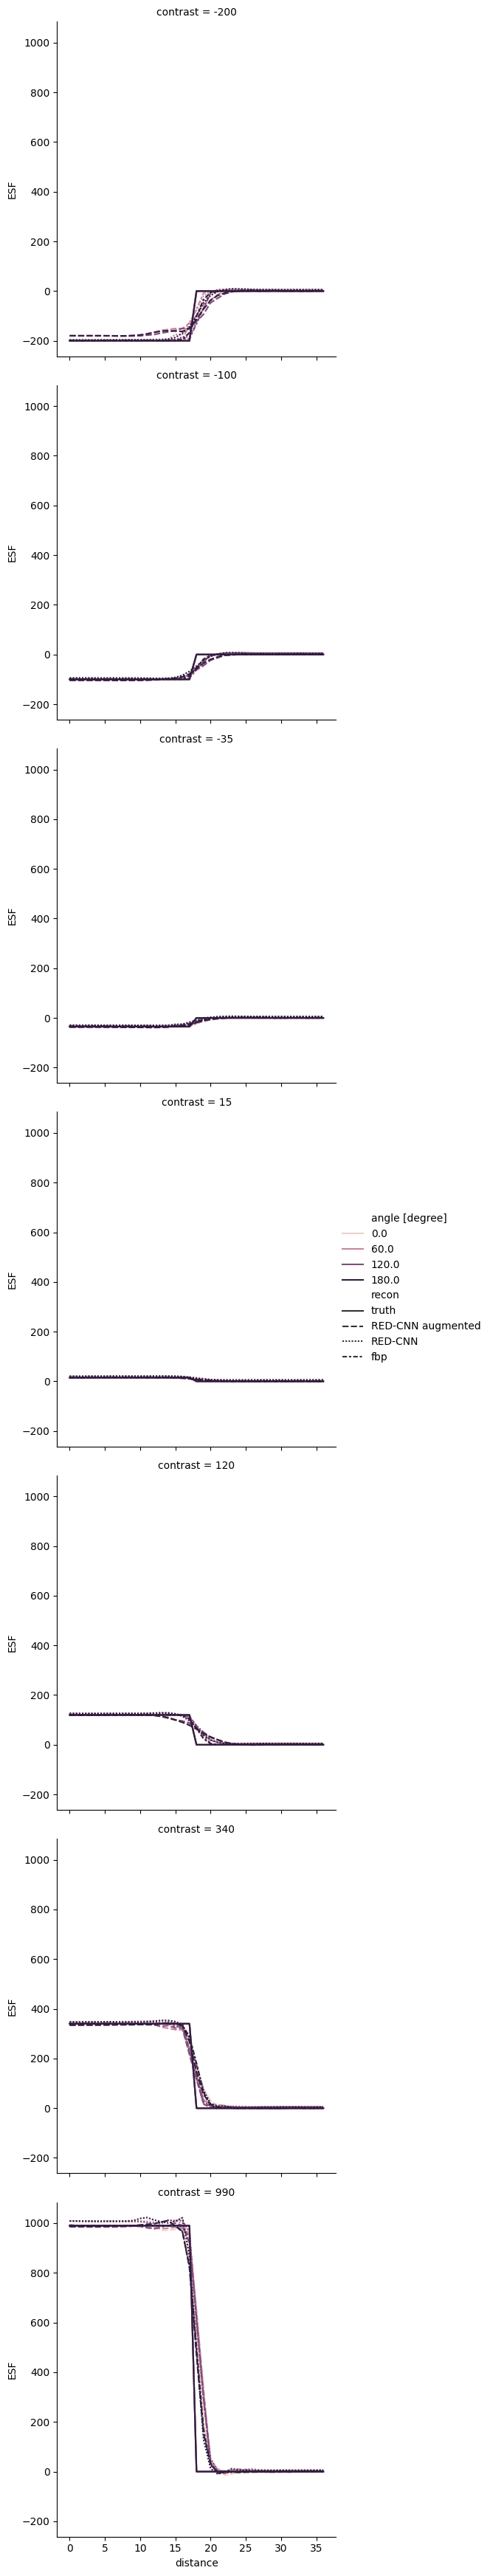

In [37]:
sns.relplot(data=esf[esf['effective diameter [cm]']==15.1], x='distance', y='ESF', hue='angle [degree]', style='recon', kind='line', row='contrast')

### Average across angles

In [38]:
def measure_averaged_esf(file, nangles=180):
    esf = measure_esf(file, nangles=nangles)
    radial_mean_esf = esf.groupby(['series', 'contrast', 'distance']).mean('ESF')
    df_list = []
    for series in esf['series'].unique():
        for contrast in esf['contrast'].unique():
            temp = esf[(esf['series']==series)&(esf['contrast']==contrast)&(esf['angle [degree]']==0)].copy().set_index('distance')
            temp.pop('angle [degree]')
            temp['ESF'] = radial_mean_esf['ESF'][series, contrast]
            df_list.append(temp.reset_index())
    return pd.concat(df_list, ignore_index=True)

In [39]:
avg_esf = measure_averaged_esf(file)
avg_esf

distance series  contrast         ESF
0           0  truth      -200 -200.000000
1           1  truth      -200 -200.000000
2           2  truth      -200 -200.000000
3           3  truth      -200 -200.000000
4           4  truth      -200 -200.000000
..        ...    ...       ...         ...
513        32  image       990    0.038333
514        33  image       990    0.097222
515        34  image       990    0.120833
516        35  image       990    0.081667
517        36  image       990    0.005000

[518 rows x 4 columns]

In [40]:
avg_esf[avg_esf.contrast==-100]

distance series  contrast         ESF
37          0  truth      -100 -100.000000
38          1  truth      -100 -100.000000
39          2  truth      -100 -100.000000
40          3  truth      -100 -100.000000
41          4  truth      -100 -100.000000
..        ...    ...       ...         ...
328        32  image      -100    0.149722
329        33  image      -100    0.173056
330        34  image      -100    0.063056
331        35  image      -100    0.133889
332        36  image      -100    0.138611

[74 rows x 4 columns]

<Axes: xlabel='distance', ylabel='ESF'>

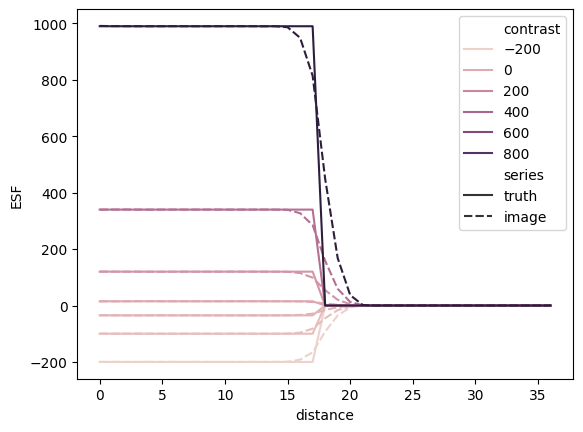

In [41]:
avg_esf = measure_averaged_esf(file, nangles=180)
sns.lineplot(data=avg_esf, x='distance', y='ESF', hue='contrast', style='series')

In [42]:
from tqdm import tqdm
nangles=180

esf_csv = Path('esf.csv')

if not esf_csv.exists():
    df_list = []
    for idx, row in tqdm(meta.iterrows()):
        file = row.file
        avg_esf = measure_averaged_esf(file, nangles=180)
        avg_esf['effective diameter [cm]']=row['effective diameter [cm]']
        avg_esf['FOV [cm]']=row['FOV [cm]']
        avg_esf['recon']=row['recon']
        avg_esf.loc[avg_esf['series']=='truth', 'recon'] = 'truth'
        avg_esf['Dose [%]']=row['Dose [%]']
        df_list.append(avg_esf)
    avg_esf = pd.concat(df_list, ignore_index=True)
    avg_esf['distance [cm]'] = avg_esf['distance'] * avg_esf['FOV [cm]']/512
    avg_esf.rename(columns={'distance':'distance [pixels]'})
    avg_esf.to_csv(esf_csv, index=False)

avg_esf = pd.read_csv(esf_csv)
avg_esf

distance series  contrast         ESF  effective diameter [cm]  \
0             0  truth      -200 -200.000000                     35.0   
1             1  truth      -200 -200.000000                     35.0   
2             2  truth      -200 -200.000000                     35.0   
3             3  truth      -200 -200.000000                     35.0   
4             4  truth      -200 -200.000000                     35.0   
...         ...    ...       ...         ...                      ...   
93067        32  image       990    0.251389                     15.1   
93068        33  image       990    0.428056                     15.1   
93069        34  image       990    0.437778                     15.1   
93070        35  image       990   -0.011944                     15.1   
93071        36  image       990   -0.282778                     15.1   

       FOV [cm]  recon  Dose [%]  distance [cm]  
0          38.5  truth        10       0.000000  
1          38.5  truth        10       0.075195  
2          38.5  truth        10       0.150391  
3          38.5  truth        10       0.225586  
4          38.5  truth        10       0.300781  
...         ...    ...       ...            ...  
93067      16.6    fbp        85       1.037500  
93068      16.6    fbp        85       1.069922  
93069      16.6    fbp        85       1.102344  
93070      16.6    fbp        85       1.134766  
93071      16.6    fbp        85       1.167188  

[93072 rows x 9 columns]

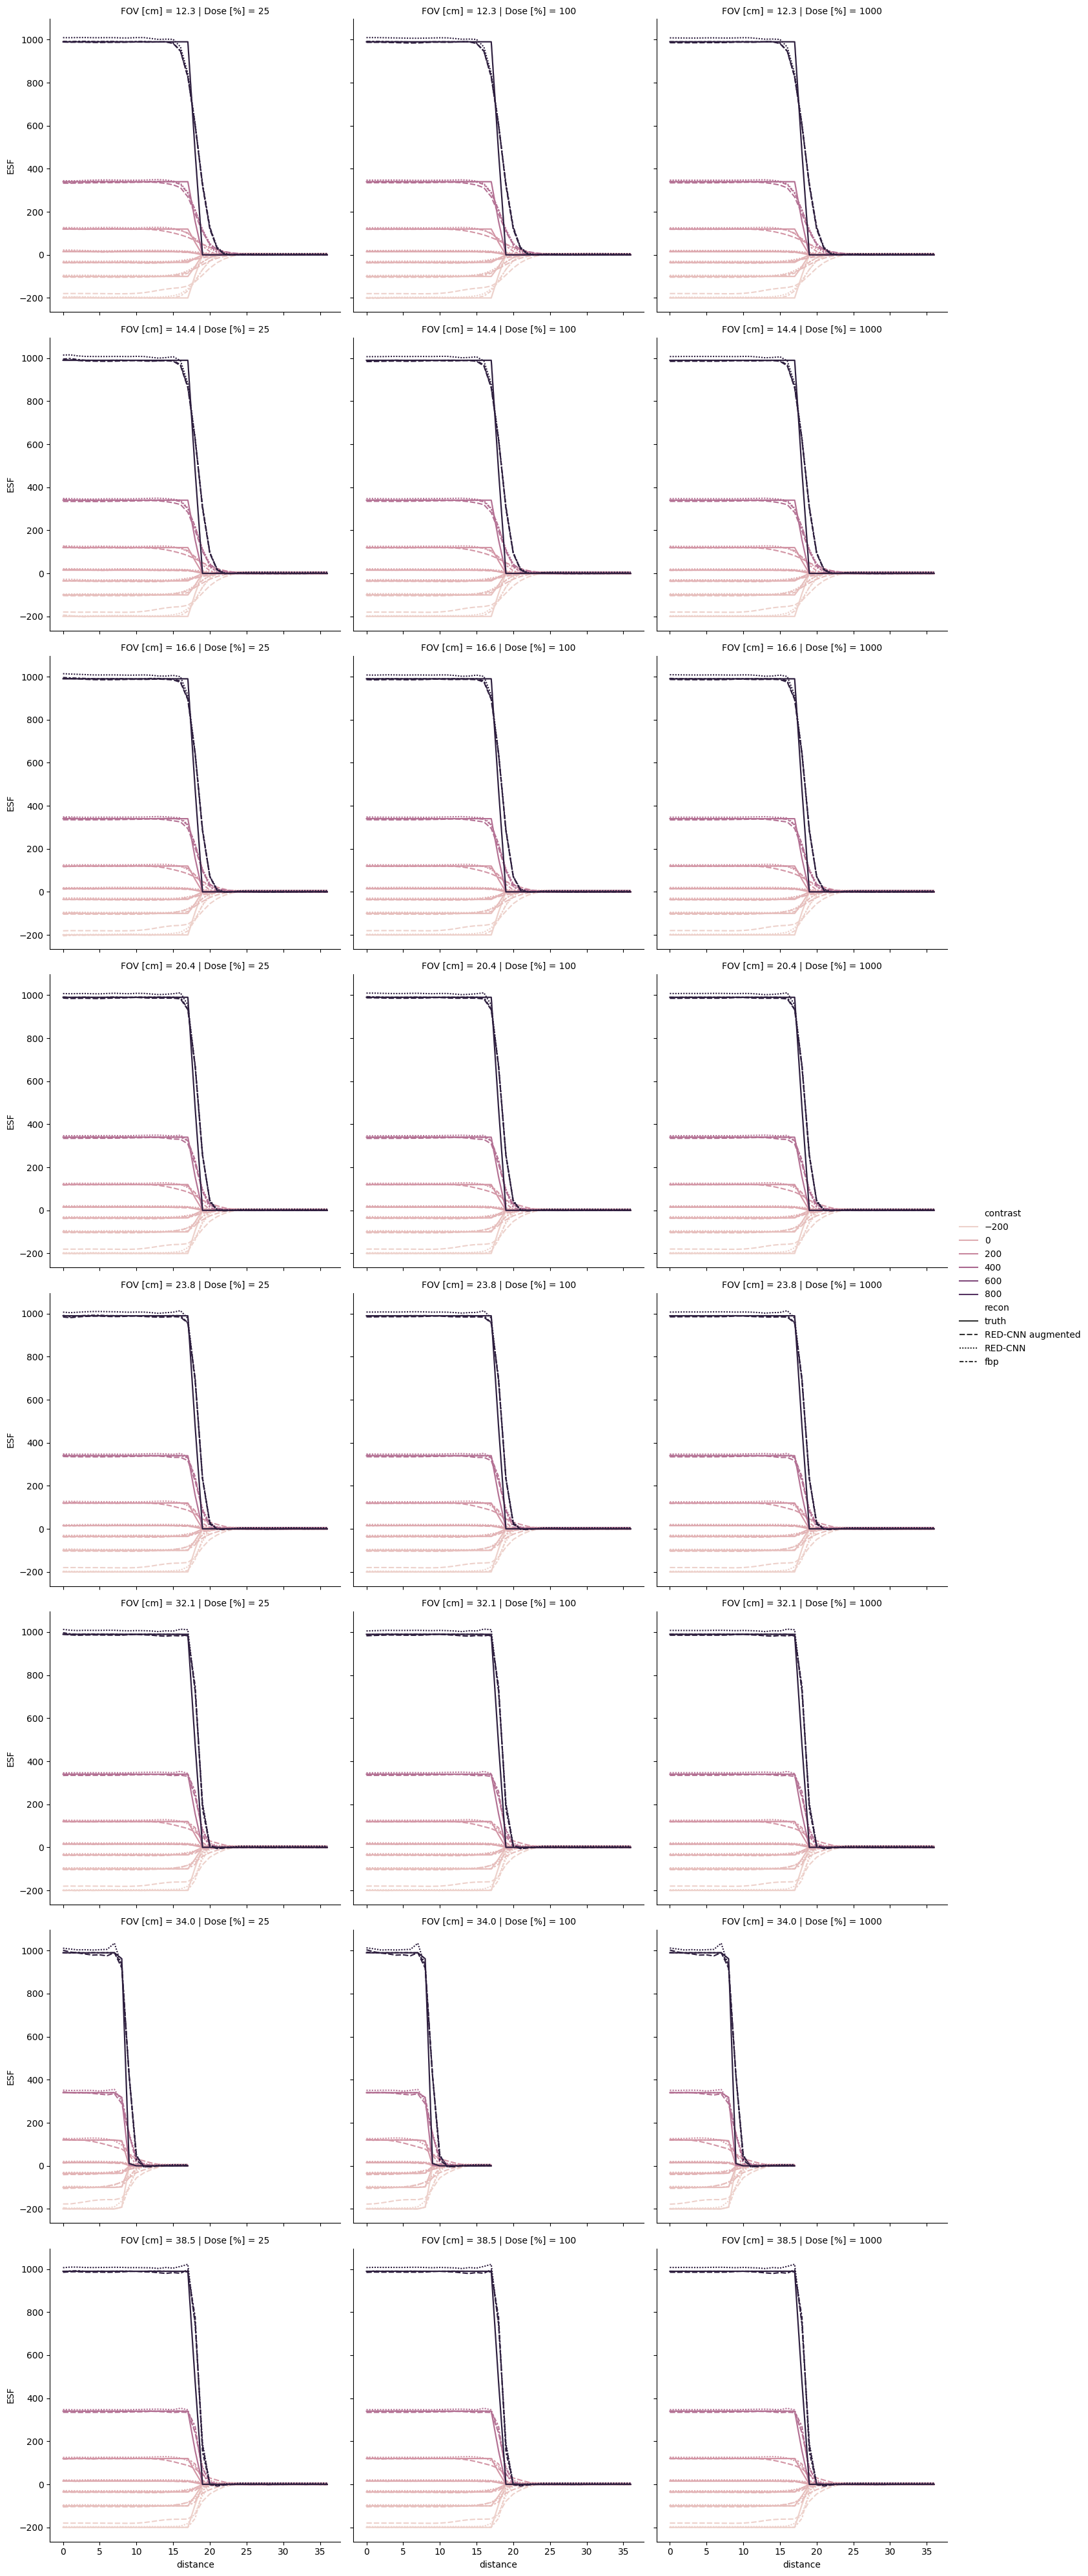

In [43]:
sns.relplot(data=avg_esf[avg_esf['Dose [%]'].isin([25, 100, 1000])], x='distance', y='ESF', hue='contrast', style='recon', kind='line', row='FOV [cm]', col='Dose [%]')

In [44]:
avg_esf['effective diameter [cm]'].unique()

array([35. , 15. , 11.2, 18.5, 21.6, 13.1, 29.2, 15.1])

In [45]:
avg_esf.contrast.unique()

array([-200, -100,  -35,   15,  120,  340,  990])

Text(0, 0.5, 'CT Number [HU]')

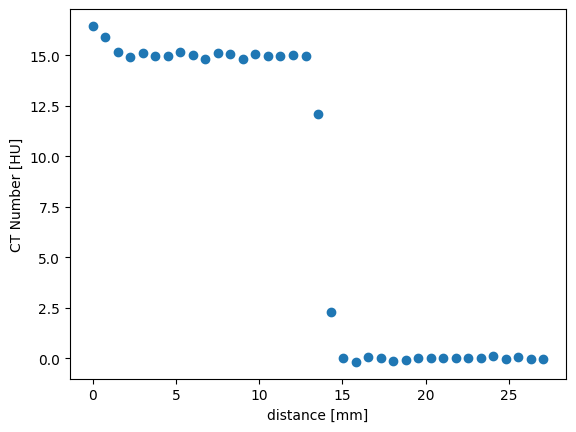

In [46]:
# avg_esf.pop('series')

esf = avg_esf[(avg_esf['contrast']==15)&(avg_esf['effective diameter [cm]']==35)&(avg_esf['recon']=='fbp')&(avg_esf['Dose [%]']==1000)].drop_duplicates()
esf = avg_esf[(avg_esf['contrast']==15)&(avg_esf['effective diameter [cm]']==35)&(avg_esf['recon']=='fbp')&(avg_esf['Dose [%]']==1000)]

pixel_size_mm = esf['FOV [cm]'].iloc[0]/512 * 10
distance = esf['distance'].to_numpy()
distance_mm = esf['distance [cm]'].to_numpy() * 10
esf_profile = esf['ESF'].to_numpy()
plt.scatter(distance_mm, esf_profile)
plt.xlabel('distance [mm]')
plt.ylabel('CT Number [HU]')

In [47]:
from scipy import interpolate
sub_vox_sz = 0.01
interpolator_pix = interpolate.interp1d(distance, esf_profile)
interpolator = interpolate.interp1d(distance_mm, esf_profile)
oversampled_distance_mm = np.arange(distance_mm.min(), distance_mm.max(), step=sub_vox_sz)
oversampled_distance_pix = np.linspace(distance.min(), distance.max(), num=len(oversampled_distance_mm))

oversampled_esf = interpolator(oversampled_distance_mm)

Text(0, 0.5, 'CT Number [HU]')

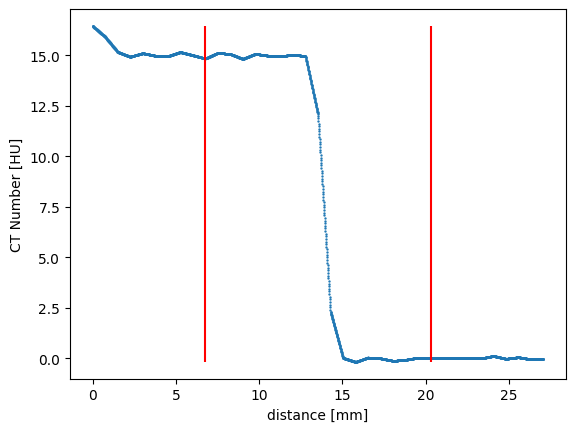

In [48]:
rel_dist_from_ends_for_means = 0.25 # larger number includes more values but risks getting to close to the edge
plt.scatter(oversampled_distance_mm, oversampled_esf, s=0.5)
plt.vlines(oversampled_distance_mm[round(len(oversampled_distance_mm)*rel_dist_from_ends_for_means)], ymin=oversampled_esf.min(), ymax=oversampled_esf.max(), color='red')
plt.vlines(oversampled_distance_mm[round(-len(oversampled_esf)*rel_dist_from_ends_for_means)], ymin=oversampled_esf.min(), ymax=oversampled_esf.max(), color='red')
plt.xlabel('distance [mm]')
plt.ylabel('CT Number [HU]')

To get the mean signal and background values average the values outside of the red lines, (equal to step 3 in [Friedman 2013](https://onlinelibrary.wiley.com/doi/abs/10.1118/1.4800795))

Now normalize so signal = 1 and background = 0 (still step 3)

0.01752562706524243 15.204518043230363


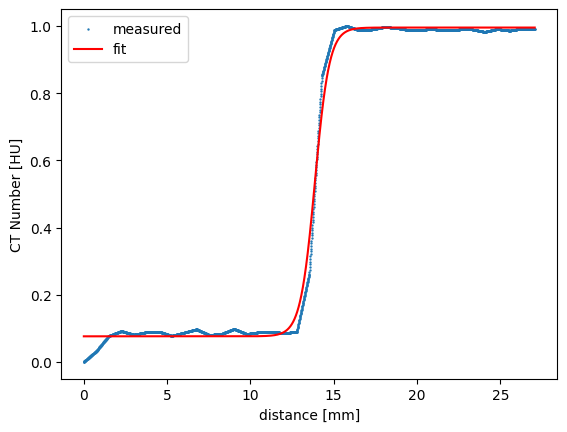

In [49]:
rel_dist_from_ends_for_means = 0.25 # larger number includes more values but risks getting to close to the edge
oversampled_esf = interpolator(oversampled_distance_mm)
mean_signal = oversampled_esf[:round(len(oversampled_distance_mm)*rel_dist_from_ends_for_means)].mean()
mean_bkg = oversampled_esf[round(-len(oversampled_esf)*rel_dist_from_ends_for_means):-1].mean()

oversampled_esf = (oversampled_esf - oversampled_esf.min())/(oversampled_esf.max() - oversampled_esf.min()) #eq. 4 Friedman 2013
# oversampled_esf = 1 - (mean_bkg - oversampled_esf)/(mean_bkg - mean_signal)
print(mean_bkg, mean_signal)
if mean_bkg < mean_signal:
    oversampled_esf= 1 - oversampled_esf
from scipy.optimize import curve_fit
def sigmoid(x, a, b, c, d):
    return a + (b - a)/(1+10**(c-x)*d)
popt, pcov = curve_fit(sigmoid, oversampled_distance_mm, oversampled_esf)
esf_fit = sigmoid(oversampled_distance_mm, *popt)

plt.scatter(oversampled_distance_mm, oversampled_esf, s=0.5, label='measured')
plt.plot(oversampled_distance_mm, esf_fit,label='fit', color='red')
plt.xlabel('distance [mm]')
plt.ylabel('CT Number [HU]')
plt.legend()
plt.show()

esf_profileke the derivative and apply a Hann window

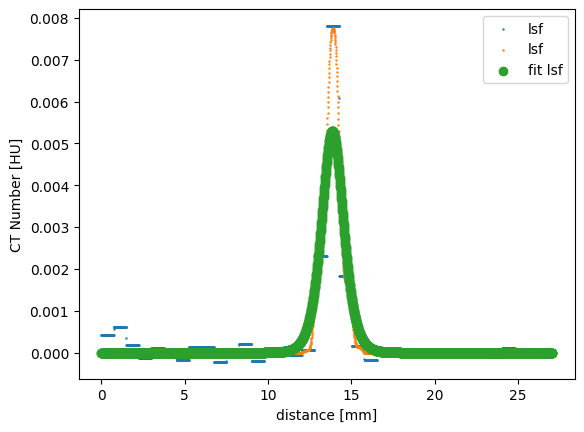

In [50]:
rel_hann_width = 0.03

# plt.scatter(oversampled_distance_mm, oversampled_esf, s=0.5, label='esf')
from scipy import signal
lsf = np.diff(oversampled_esf)

hann_width = round(len(lsf)*rel_hann_width)
win = signal.windows.hann(hann_width)
filtered_lsf = signal.convolve(lsf, win, mode='same') / sum(win)
filtered_lsf *= signal.windows.hann(len(filtered_lsf))**4
filtered_lsf[:round(len(oversampled_distance_mm)*rel_dist_from_ends_for_means)]=0
filtered_lsf[-round(len(oversampled_distance_mm)*rel_dist_from_ends_for_means):]=0
filtered_lsf[filtered_lsf<0]=0
plt.xlabel('distance [mm]')
plt.ylabel('CT Number [HU]')
plt.scatter(oversampled_distance_mm[:-1], lsf, s=0.5, label='lsf')
plt.scatter(oversampled_distance_mm[:-1], filtered_lsf, s=0.5, label='lsf')
plt.scatter(oversampled_distance_mm[:-1],  np.diff(esf_fit), label='fit lsf')
plt.legend()

**Get spatial frequencies for both pixels and mm and save both to dataframes**

In [51]:
def distance_to_spatial_frequencies(distance_array):
    delta_freq = 1/distance_array.max()
    max_freq = 1/np.diff(distance_array)[0]
    sampled_freq = np.arange(0, max_freq, delta_freq)
    return sampled_freq

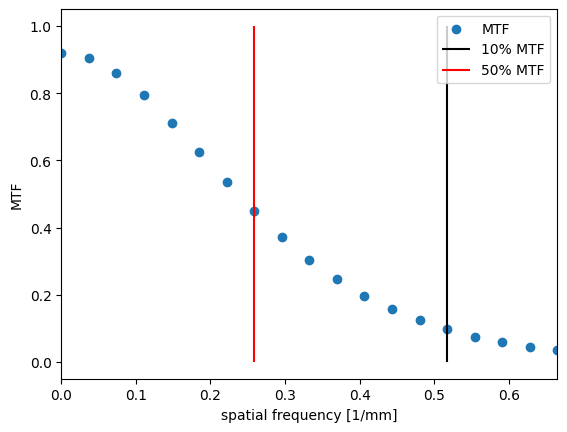

In [52]:
freq_invmm = distance_to_spatial_frequencies(oversampled_distance_mm)
freq_invpx = distance_to_spatial_frequencies(oversampled_distance_pix)
cutoff_freq = 1/pixel_size_mm/2 #nyquist freq
# mtf = np.abs(np.fft.fft(filtered_lsf))
mtf = np.abs(np.fft.fft(np.diff(esf_fit)))


if len(mtf)<len(freq_invmm):
    mtf = np.append(mtf, 0)

plt.scatter(freq_invmm, mtf, label='MTF')
plt.vlines(freq_invmm[np.argwhere(mtf<0.1)[0]], ymin=0, ymax=1, label='10% MTF', color='black')
plt.vlines(freq_invmm[np.argwhere(mtf<0.5)[0]], ymin=0, ymax=1, label='50% MTF', color='red')
plt.xlim([0, cutoff_freq])
plt.xlabel('spatial frequency [1/mm]')
plt.ylabel('MTF')
plt.legend()

https://onlinelibrary.wiley.com/doi/abs/10.1118/1.4800795 see on MTF

package into function

In [53]:
cutoff_freq_idx=np.argwhere(freq_invmm > cutoff_freq).squeeze()[0]
mtf_df = pd.DataFrame({'spatial frequency [1/mm]': freq_invmm[:cutoff_freq_idx],
                       'spatial frequency [1/px]': freq_invpx[:cutoff_freq_idx],
                       'MTF': mtf[:cutoff_freq_idx]})
mtf_df.head()

spatial frequency [1/mm]  spatial frequency [1/px]       MTF
0                  0.000000                  0.000000  0.918955
1                  0.036941                  0.027778  0.903773
2                  0.073883                  0.055556  0.860273
3                  0.110824                  0.083333  0.794002
4                  0.147765                  0.111111  0.712514

Now add columns for FOV, diameter, recon, dose and append all...

<Axes: xlabel='spatial frequency [1/px]'>

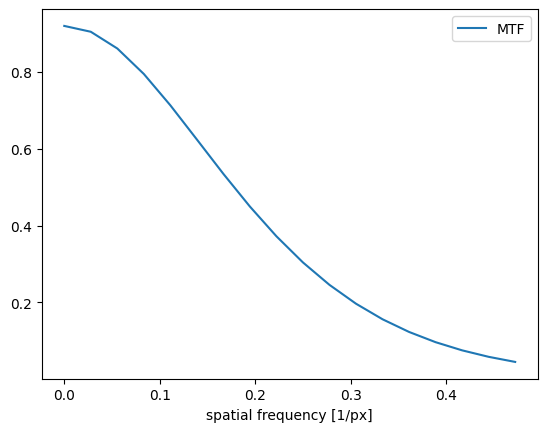

In [54]:
mtf_df.plot(x='spatial frequency [1/px]', y='MTF')

In [55]:
from scipy import interpolate, signal
from scipy.optimize import curve_fit
from results_utils import sigmoid, measure_mtf


In [56]:
avg_esf['contrast'].unique()

array([-200, -100,  -35,   15,  120,  340,  990])

The negative values are good, but there's something up with the 15. 120. 340, 990 not have MTF 1 at 0 freq

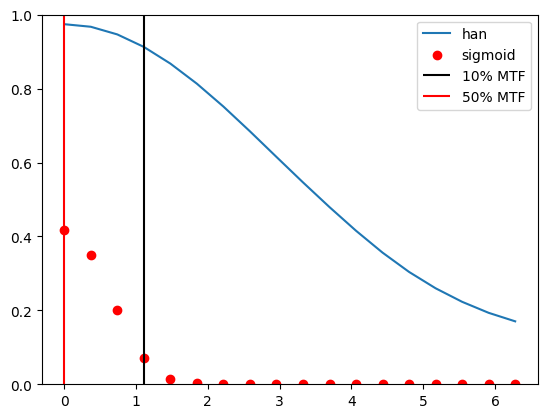

In [57]:
esf = avg_esf[(avg_esf['contrast']==-100)&(avg_esf['effective diameter [cm]']==35)&(avg_esf['recon']=='fbp')&(avg_esf['Dose [%]']==1000)]
distance = esf['distance [cm]'].to_numpy()
esf_profile = esf['ESF'].to_numpy()

m, f = measure_mtf(esf_profile, distance=distance, sigmoid_fit=False)
plt.plot(f, m, label='han')
m, f = measure_mtf(esf_profile, distance=distance, sigmoid_fit=True)
plt.scatter(f, m, label='sigmoid', color='red')
if (m<0.1).any():
    plt.vlines(f[np.argwhere(m<0.1)[0]], ymin=0, ymax=1, label='10% MTF', color='black')
plt.vlines(f[np.argwhere(m<0.5)[0]], ymin=0, ymax=1, label='50% MTF', color='red')
plt.legend()
plt.ylim([0, 1])
plt.show()

Double check ground truth as this should be 1 or close

TODO: make unique labels for each line profile so they are easier to select eg: 15 cm fbp dose 100 80 contrast (or a integer id)

In [58]:
from results_utils import make_mtf_df

mtf_df = make_mtf_df(avg_esf, sigmoid_fit=False)

100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


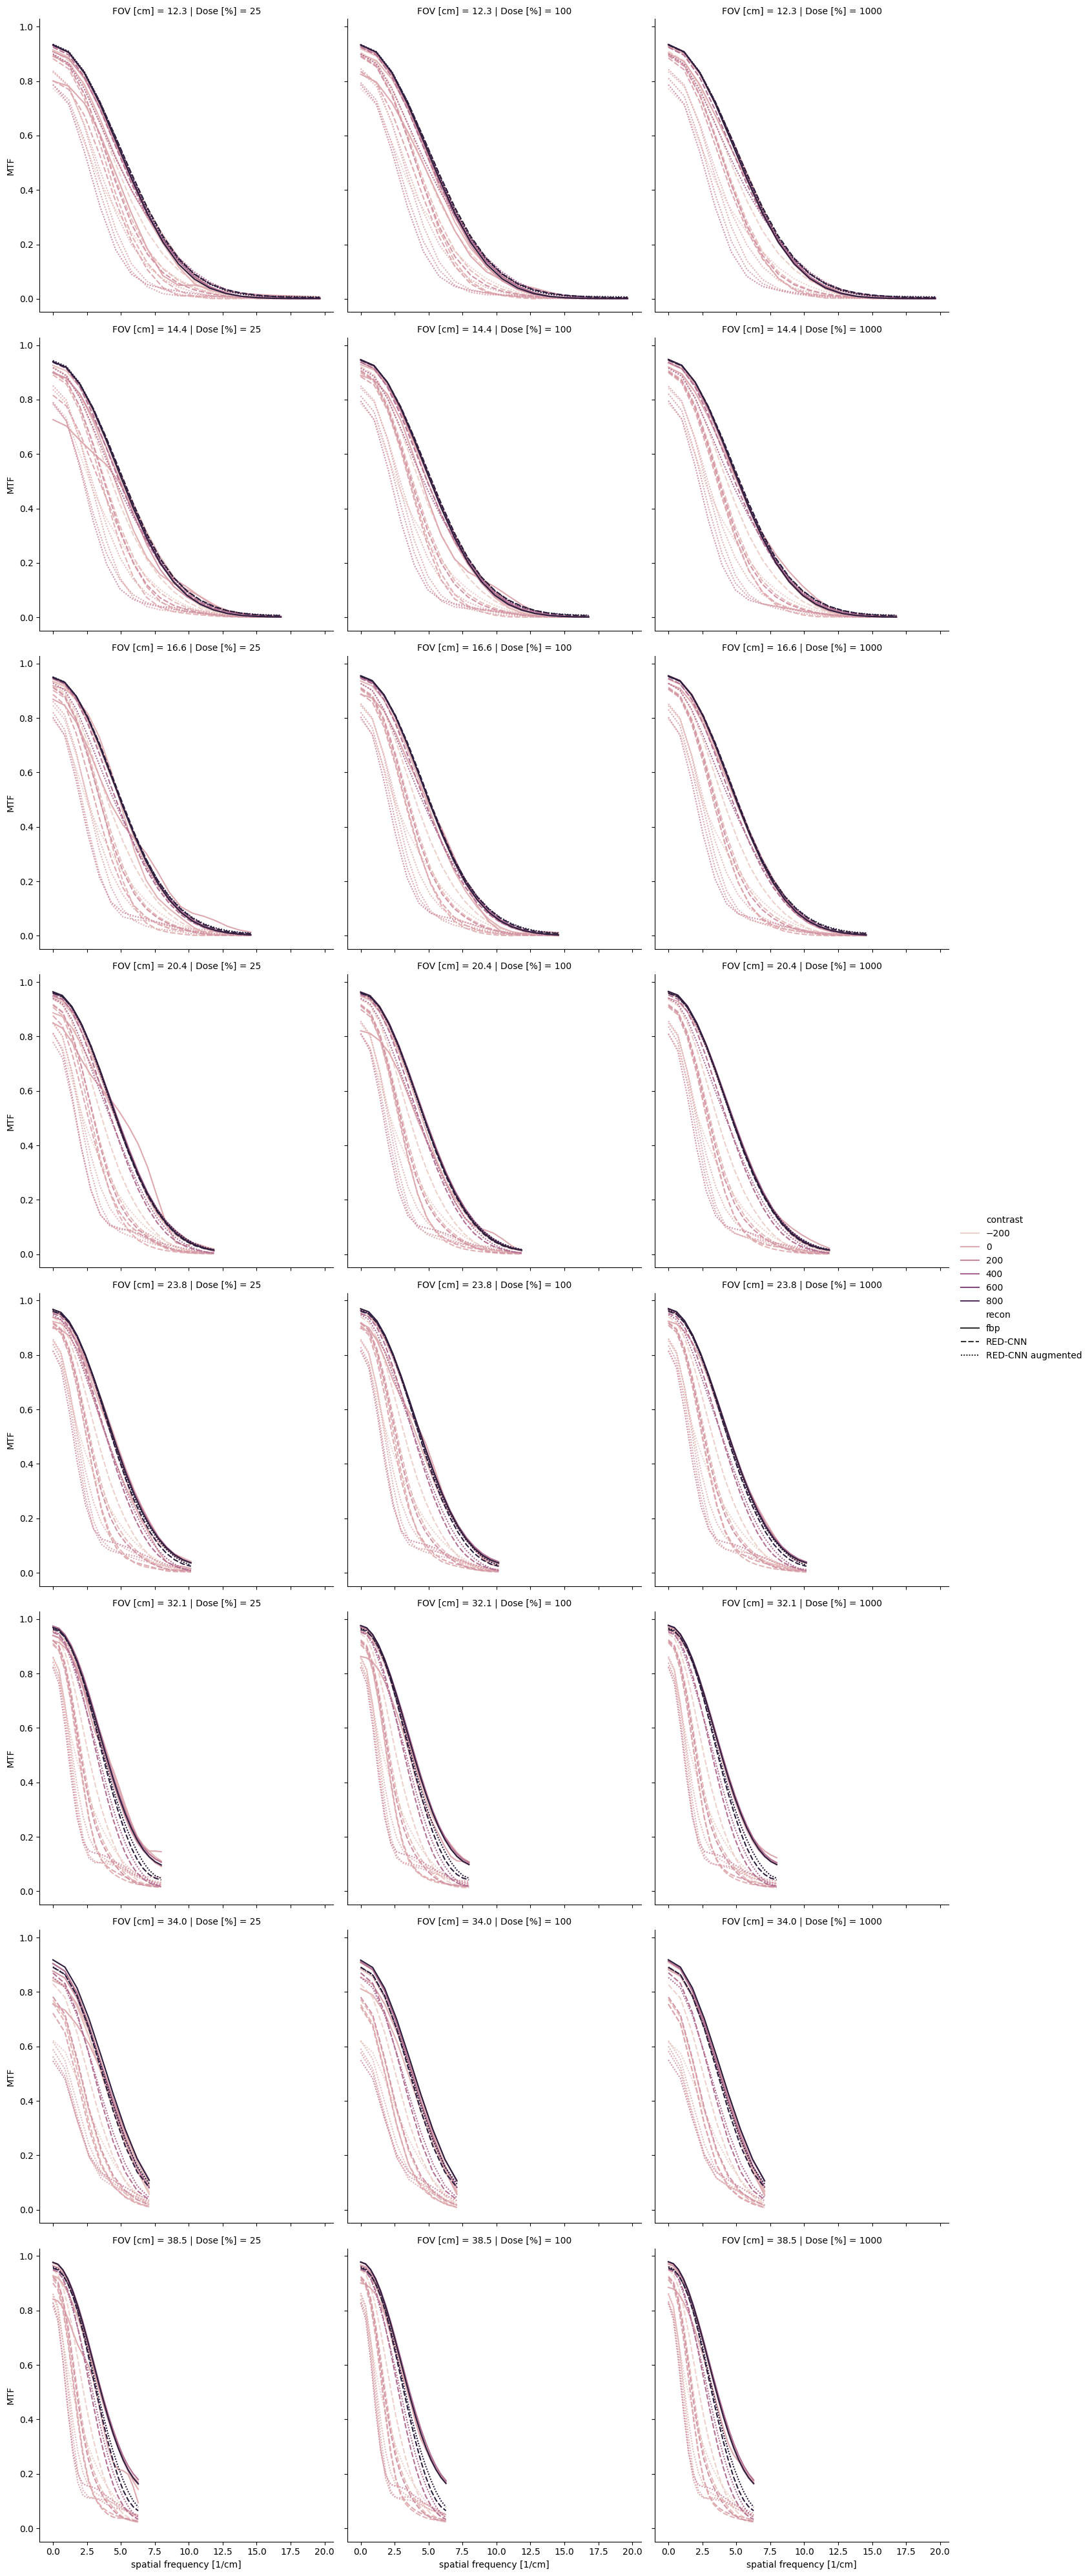

In [59]:
sns.relplot(data=mtf_df[mtf_df['Dose [%]'].isin([25, 100, 1000])], x='spatial frequency [1/cm]', y='MTF', hue='contrast', style='recon', style_order=['fbp', 'RED-CNN', 'RED-CNN augmented'], kind='line', row='FOV [cm]', col='Dose [%]')

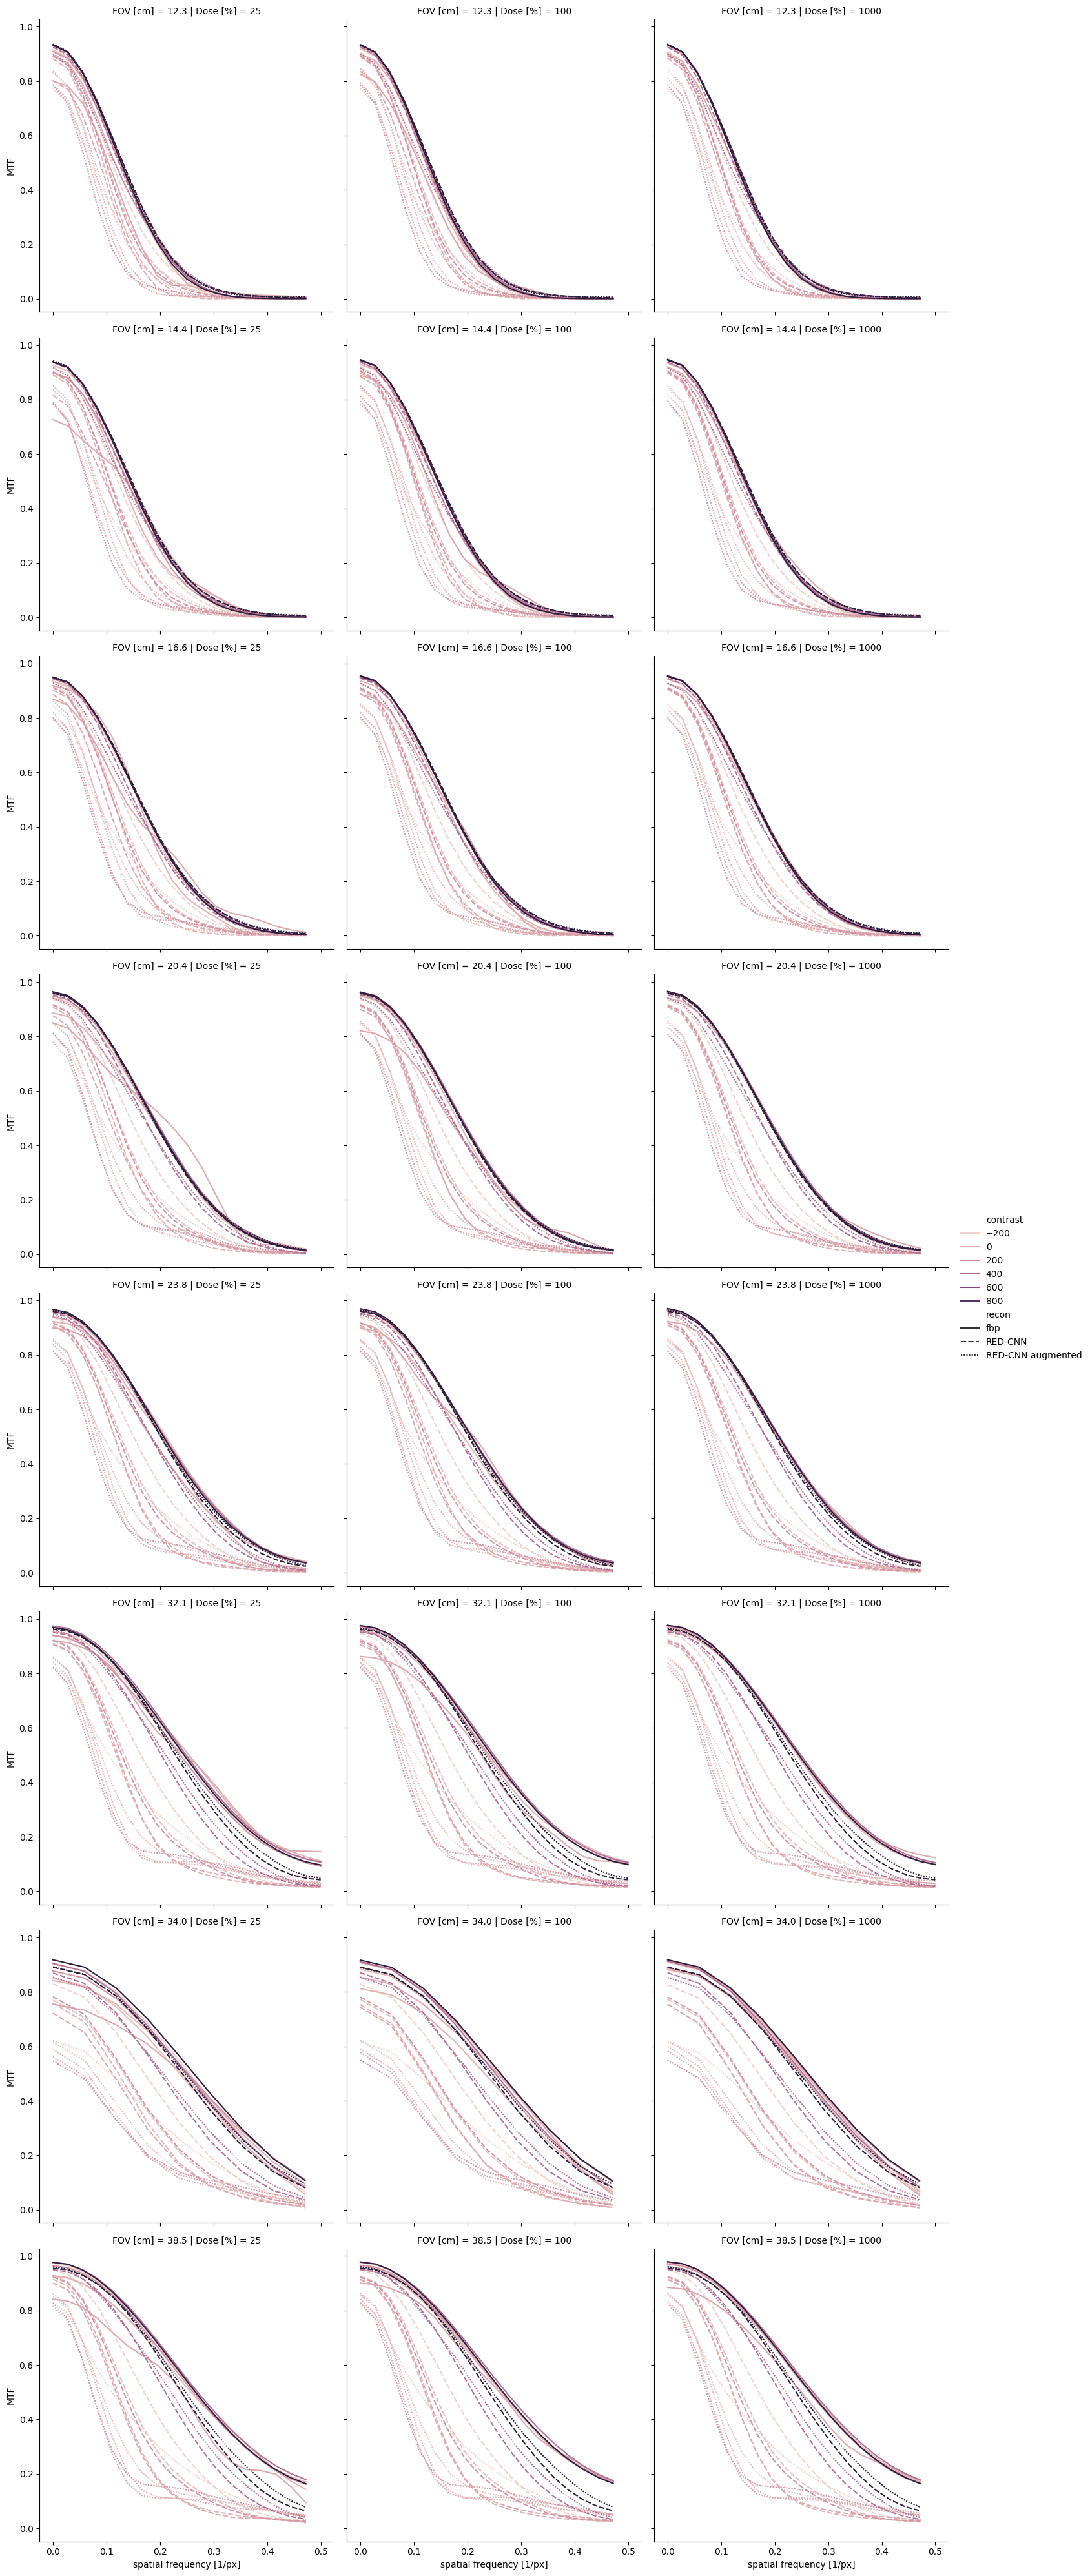

In [60]:
sns.relplot(data=mtf_df[mtf_df['Dose [%]'].isin([25, 100, 1000])], x='spatial frequency [1/px]', y='MTF', hue='contrast', style='recon', style_order=['fbp', 'RED-CNN', 'RED-CNN augmented'], kind='line', row='FOV [cm]', col='Dose [%]')

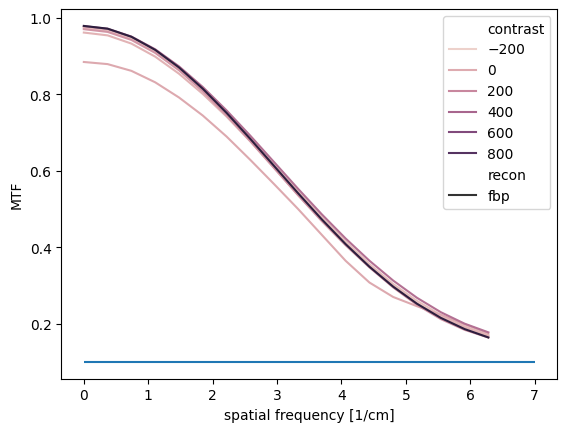

In [61]:
from utils import pediatric_subgroup
mtf_df['pediatric subgroup'] = mtf_df['effective diameter [cm]'].apply(pediatric_subgroup)
f, ax = plt.subplots()
sns.lineplot(data=mtf_df[mtf_df['Dose [%]'].isin([1000]) & (mtf_df['pediatric subgroup']=='adult') & (mtf_df.recon=='fbp')], x='spatial frequency [1/cm]', y='MTF', hue='contrast', style='recon', ax=ax)
ax.hlines(y=0.1, xmin=0, xmax=7)

This looks pretty good thought the dip in the ground truth is a little strange, it could be because some of the angles in the radial profile have profiles that are misaligned that is blurring the average, but all together the trends are as expected

<Axes: xlabel='spatial frequency [1/cm]'>

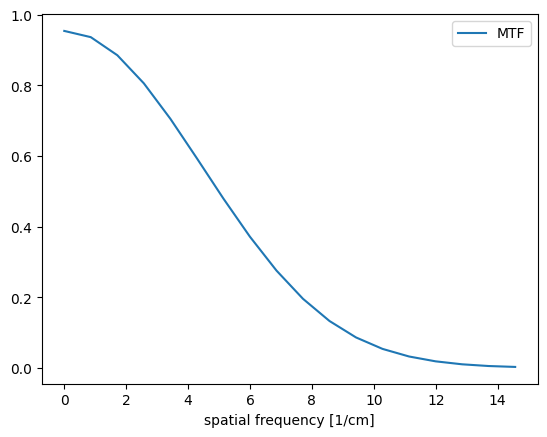

In [62]:
names = mtf_df.name.unique()
name = names[-1]
mtf_df[mtf_df.name == name].plot(x='spatial frequency [1/cm]', y='MTF')

In [63]:
mtf_df[mtf_df.recon=='truth']

name  effective diameter [cm]  FOV [cm]  \
0      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
1      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
2      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
3      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
4      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
...                               ...                      ...       ...   
30081   15.1 cm 85% dose truth 990 HU                     15.1      16.6   
30082   15.1 cm 85% dose truth 990 HU                     15.1      16.6   
30083   15.1 cm 85% dose truth 990 HU                     15.1      16.6   
30084   15.1 cm 85% dose truth 990 HU                     15.1      16.6   
30085   15.1 cm 85% dose truth 990 HU                     15.1      16.6   

       Dose [%]  recon  contrast  spatial frequency [1/cm]  \
0            10  truth      -200                  0.000000   
1            10  truth      -200                  0.369408   
2            10  truth      -200                  0.738817   
3            10  truth      -200                  1.108225   
4            10  truth      -200                  1.477633   
...         ...    ...       ...                       ...   
30081        85  truth       990                 11.137885   
30082        85  truth       990                 11.994645   
30083        85  truth       990                 12.851406   
30084        85  truth       990                 13.708166   
30085        85  truth       990                 14.564926   

       spatial frequency [1/px]       MTF pediatric subgroup  
0                      0.000000  0.988828              adult  
1                      0.027778  0.983342              adult  
2                      0.055556  0.967006              adult  
3                      0.083333  0.940191              adult  
4                      0.111111  0.903497              adult  
...                         ...       ...                ...  
30081                  0.361111  0.310902            newborn  
30082                  0.388889  0.240997            newborn  
30083                  0.416667  0.175212            newborn  
30084                  0.444444  0.114772            newborn  
30085                  0.472222  0.061436            newborn  

[7616 rows x 10 columns]

In [64]:
set_NA_to_min = True
for name in mtf_df.name.unique():
    mtf = mtf_df[(mtf_df.name == name)]['MTF']
    if mtf.min() < 0.5:
        mtf_df.loc[mtf_df.name == name, 'MTF 50% [1/cm]'] = mtf_df[(mtf_df.name == name)&(mtf_df['MTF']<0.5)].iloc[0]['spatial frequency [1/cm]']
        mtf_df.loc[mtf_df.name == name, 'MTF 50% [1/px]'] = mtf_df[(mtf_df.name == name)&(mtf_df['MTF']<0.5)].iloc[0]['spatial frequency [1/px]']
    if mtf.min() < 0.1:
        mtf_df.loc[mtf_df.name == name, 'MTF 10% [1/cm]'] = mtf_df[(mtf_df.name == name)&(mtf_df['MTF']<0.1)].iloc[0]['spatial frequency [1/cm]']
        mtf_df.loc[mtf_df.name == name, 'MTF 10% [1/px]'] = mtf_df[(mtf_df.name == name)&(mtf_df['MTF']<0.1)].iloc[0]['spatial frequency [1/px]']
    
    if set_NA_to_min:
       # WARNING these are not exactly the 50 and 10% values, but just take the lowest if those aren't available, need to figure out how to handle this later
        if mtf.min() > 0.5:
            mtf_df.loc[mtf_df.name == name, 'MTF 50% [1/cm]'] = mtf_df[(mtf_df.name == name)].iloc[-1]['spatial frequency [1/cm]']
            mtf_df.loc[mtf_df.name == name, 'MTF 50% [1/px]'] = mtf_df[(mtf_df.name == name)].iloc[-1]['spatial frequency [1/px]']
        if mtf.min() > 0.1:
            mtf_df.loc[mtf_df.name == name, 'MTF 10% [1/cm]'] = mtf_df[(mtf_df.name == name)].iloc[-1]['spatial frequency [1/cm]']
            mtf_df.loc[mtf_df.name == name, 'MTF 10% [1/px]'] = mtf_df[(mtf_df.name == name)].iloc[-1]['spatial frequency [1/px]']
mtf_df

name  effective diameter [cm]  FOV [cm]  \
0      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
1      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
2      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
3      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
4      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
...                               ...                      ...       ...   
30459     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30460     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30461     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30462     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30463     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   

       Dose [%]  recon  contrast  spatial frequency [1/cm]  \
0            10  truth      -200                  0.000000   
1            10  truth      -200                  0.369408   
2            10  truth      -200                  0.738817   
3            10  truth      -200                  1.108225   
4            10  truth      -200                  1.477633   
...         ...    ...       ...                       ...   
30459        85    fbp       990                 11.137885   
30460        85    fbp       990                 11.994645   
30461        85    fbp       990                 12.851406   
30462        85    fbp       990                 13.708166   
30463        85    fbp       990                 14.564926   

       spatial frequency [1/px]       MTF pediatric subgroup  MTF 50% [1/cm]  \
0                      0.000000  0.988828              adult        4.063492   
1                      0.027778  0.983342              adult        4.063492   
2                      0.055556  0.967006              adult        4.063492   
3                      0.083333  0.940191              adult        4.063492   
4                      0.111111  0.903497              adult        4.063492   
...                         ...       ...                ...             ...   
30459                  0.361111  0.032775            newborn        5.140562   
30460                  0.388889  0.019083            newborn        5.140562   
30461                  0.416667  0.010693            newborn        5.140562   
30462                  0.444444  0.005836            newborn        5.140562   
30463                  0.472222  0.003286            newborn        5.140562   

       MTF 50% [1/px]  MTF 10% [1/cm]  MTF 10% [1/px]  
0            0.305556        6.279942        0.472222  
1            0.305556        6.279942        0.472222  
2            0.305556        6.279942        0.472222  
3            0.305556        6.279942        0.472222  
4            0.305556        6.279942        0.472222  
...               ...             ...             ...  
30459        0.166667        9.424364        0.305556  
30460        0.166667        9.424364        0.305556  
30461        0.166667        9.424364        0.305556  
30462        0.166667        9.424364        0.305556  
30463        0.166667        9.424364        0.305556  

[30464 rows x 14 columns]

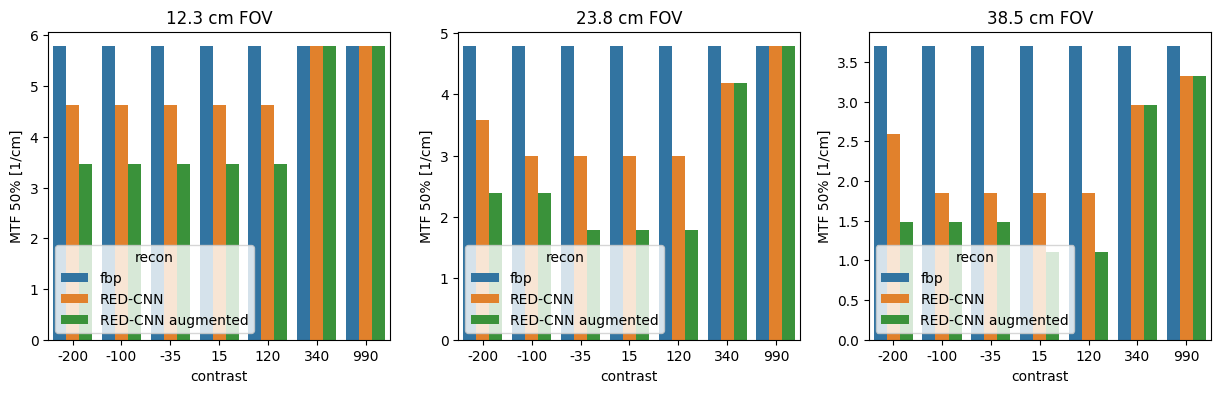

In [65]:
f, axs = plt.subplots(1,3, figsize=(15, 4))
for ax, fov in zip(axs.flatten(), [12.3, 23.8, 38.5]):
    sns.barplot(ax=ax, data=mtf_df[(mtf_df['Dose [%]']==1000)&(mtf_df['FOV [cm]']==fov)], x='contrast', y='MTF 50% [1/cm]', hue='recon', hue_order=['fbp', 'RED-CNN', 'RED-CNN augmented'])
    ax.set_title(f'{fov} cm FOV')

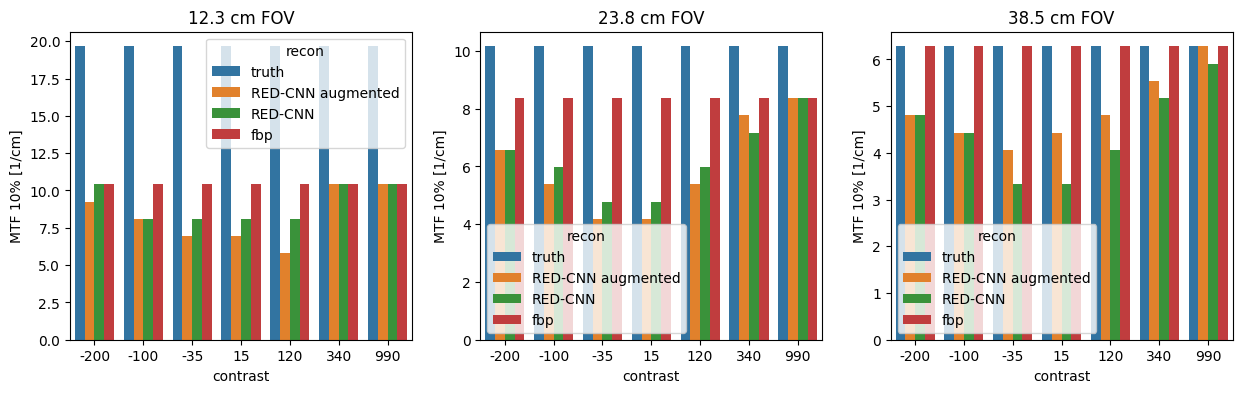

In [66]:
f, axs = plt.subplots(1,3, figsize=(15, 4))
for ax, fov in zip(axs.flatten(), [12.3, 23.8, 38.5]):
    sns.barplot(ax=ax, data=mtf_df[(mtf_df['Dose [%]']==1000)&(mtf_df['FOV [cm]']==fov)], x='contrast', y='MTF 10% [1/cm]', hue='recon')
    ax.set_title(f'{fov} cm FOV')

In [67]:
from utils import pediatric_subgroup
mtf_df['pediatric subgroup'] = mtf_df['effective diameter [cm]'].apply(pediatric_subgroup)

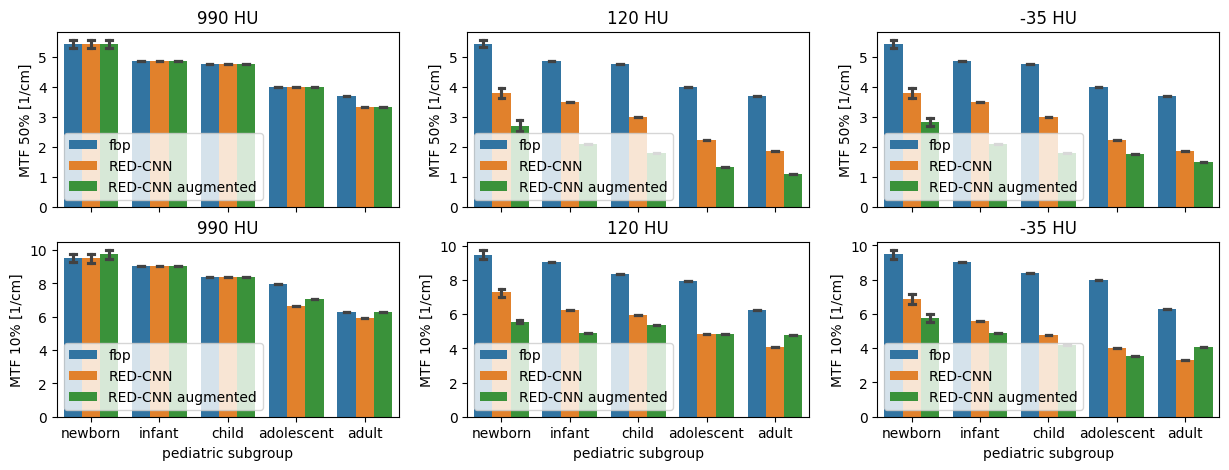

In [68]:
f, axs = plt.subplots(2,3, figsize=(15, 5), sharex=True)

for row, mtf_cutoff in enumerate([50, 10]):
    for col, contrast in enumerate([990, 120, -35]):
        sns.barplot(ax=axs[row, col], data=mtf_df[(mtf_df['Dose [%]']==1000)&(mtf_df['contrast']==contrast)], x='pediatric subgroup', y=f'MTF {mtf_cutoff}% [1/cm]', hue='recon', hue_order=['fbp', 'RED-CNN', 'RED-CNN augmented'], order=['newborn', 'infant', 'child', 'adolescent', 'adult'], capsize=0.25)
        axs[row, col].set_title(f'{contrast} HU')
        axs[row, col].legend(loc='lower left')

In [69]:
mtf_df

name  effective diameter [cm]  FOV [cm]  \
0      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
1      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
2      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
3      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
4      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
...                               ...                      ...       ...   
30459     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30460     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30461     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30462     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30463     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   

       Dose [%]  recon  contrast  spatial frequency [1/cm]  \
0            10  truth      -200                  0.000000   
1            10  truth      -200                  0.369408   
2            10  truth      -200                  0.738817   
3            10  truth      -200                  1.108225   
4            10  truth      -200                  1.477633   
...         ...    ...       ...                       ...   
30459        85    fbp       990                 11.137885   
30460        85    fbp       990                 11.994645   
30461        85    fbp       990                 12.851406   
30462        85    fbp       990                 13.708166   
30463        85    fbp       990                 14.564926   

       spatial frequency [1/px]       MTF pediatric subgroup  MTF 50% [1/cm]  \
0                      0.000000  0.988828              adult        4.063492   
1                      0.027778  0.983342              adult        4.063492   
2                      0.055556  0.967006              adult        4.063492   
3                      0.083333  0.940191              adult        4.063492   
4                      0.111111  0.903497              adult        4.063492   
...                         ...       ...                ...             ...   
30459                  0.361111  0.032775            newborn        5.140562   
30460                  0.388889  0.019083            newborn        5.140562   
30461                  0.416667  0.010693            newborn        5.140562   
30462                  0.444444  0.005836            newborn        5.140562   
30463                  0.472222  0.003286            newborn        5.140562   

       MTF 50% [1/px]  MTF 10% [1/cm]  MTF 10% [1/px]  
0            0.305556        6.279942        0.472222  
1            0.305556        6.279942        0.472222  
2            0.305556        6.279942        0.472222  
3            0.305556        6.279942        0.472222  
4            0.305556        6.279942        0.472222  
...               ...             ...             ...  
30459        0.166667        9.424364        0.305556  
30460        0.166667        9.424364        0.305556  
30461        0.166667        9.424364        0.305556  
30462        0.166667        9.424364        0.305556  
30463        0.166667        9.424364        0.305556  

[30464 rows x 14 columns]

In [70]:
mtf_df

name  effective diameter [cm]  FOV [cm]  \
0      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
1      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
2      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
3      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
4      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
...                               ...                      ...       ...   
30459     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30460     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30461     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30462     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
30463     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   

       Dose [%]  recon  contrast  spatial frequency [1/cm]  \
0            10  truth      -200                  0.000000   
1            10  truth      -200                  0.369408   
2            10  truth      -200                  0.738817   
3            10  truth      -200                  1.108225   
4            10  truth      -200                  1.477633   
...         ...    ...       ...                       ...   
30459        85    fbp       990                 11.137885   
30460        85    fbp       990                 11.994645   
30461        85    fbp       990                 12.851406   
30462        85    fbp       990                 13.708166   
30463        85    fbp       990                 14.564926   

       spatial frequency [1/px]       MTF pediatric subgroup  MTF 50% [1/cm]  \
0                      0.000000  0.988828              adult        4.063492   
1                      0.027778  0.983342              adult        4.063492   
2                      0.055556  0.967006              adult        4.063492   
3                      0.083333  0.940191              adult        4.063492   
4                      0.111111  0.903497              adult        4.063492   
...                         ...       ...                ...             ...   
30459                  0.361111  0.032775            newborn        5.140562   
30460                  0.388889  0.019083            newborn        5.140562   
30461                  0.416667  0.010693            newborn        5.140562   
30462                  0.444444  0.005836            newborn        5.140562   
30463                  0.472222  0.003286            newborn        5.140562   

       MTF 50% [1/px]  MTF 10% [1/cm]  MTF 10% [1/px]  
0            0.305556        6.279942        0.472222  
1            0.305556        6.279942        0.472222  
2            0.305556        6.279942        0.472222  
3            0.305556        6.279942        0.472222  
4            0.305556        6.279942        0.472222  
...               ...             ...             ...  
30459        0.166667        9.424364        0.305556  
30460        0.166667        9.424364        0.305556  
30461        0.166667        9.424364        0.305556  
30462        0.166667        9.424364        0.305556  
30463        0.166667        9.424364        0.305556  

[30464 rows x 14 columns]

In [71]:
mtf_df = mtf_df.copy()
cols = ['effective diameter [cm]', 'Dose [%]', 'contrast']
means = mtf_df.groupby(cols).mean('MTF 50% [1/cm]')

In [72]:
means

FOV [cm]  spatial frequency [1/cm]  \
effective diameter [cm] Dose [%] contrast                                       
11.2                    10       -200          12.3                  9.828365   
                                 -100          12.3                  9.828365   
                                 -35           12.3                  9.828365   
                                  15           12.3                  9.828365   
                                  120          12.3                  9.828365   
...                                             ...                       ...   
35.0                    1000     -35           38.5                  3.139971   
                                  15           38.5                  3.139971   
                                  120          38.5                  3.139971   
                                  340          38.5                  3.139971   
                                  990          38.5                  3.139971   

                                           spatial frequency [1/px]       MTF  \
effective diameter [cm] Dose [%] contrast                                       
11.2                    10       -200                      0.236111  0.334523   
                                 -100                      0.236111  0.333772   
                                 -35                       0.236111  0.306436   
                                  15                       0.236111  0.321550   
                                  120                      0.236111  0.315717   
...                                                             ...       ...   
35.0                    1000     -35                       0.236111  0.428536   
                                  15                       0.236111  0.416193   
                                  120                      0.236111  0.435470   
                                  340                      0.236111  0.531578   
                                  990                      0.236111  0.556399   

                                           MTF 50% [1/cm]  MTF 50% [1/px]  \
effective diameter [cm] Dose [%] contrast                                   
11.2                    10       -200            6.937669        0.166667   
                                 -100            6.648600        0.159722   
                                 -35             6.359530        0.152778   
                                  15             6.648600        0.159722   
                                  120            6.648600        0.159722   
...                                                   ...             ...   
35.0                    1000     -35             2.770563        0.208333   
                                  15             2.678211        0.201389   
                                  120            2.678211        0.201389   
                                  340            3.417027        0.256944   
                                  990            3.601732        0.270833   

                                           MTF 10% [1/cm]  MTF 10% [1/px]  
effective diameter [cm] Dose [%] contrast                                  
11.2                    10       -200           12.429991        0.298611  
                                 -100           11.851852        0.284722  
                                 -35            11.273713        0.270833  
                                  15            11.851852        0.284722  
                                  120           10.984643        0.263889  
...                                                   ...             ...  
35.0                    1000     -35             4.987013        0.375000  
                                  15             5.079365        0.381944  
                                  120            5.356421        0.402778  
                                  340            5.818182        0.437500  
                     

In [73]:
from tqdm import tqdm
def measure_relative_mtf(mtf_df):
    mtf_df = mtf_df.copy()
    cols = ['effective diameter [cm]', 'Dose [%]', 'contrast', 'recon',]
    means = mtf_df.groupby(cols).mean('MTF 50% [1/cm]')

    rows = []
    for idx, row in tqdm(mtf_df.iterrows(), total=len(mtf_df)):
        row_mtf = means['MTF 50% [1/cm]'][row[cols[0]], int(row[cols[1]]), *row[cols[2:]].to_list()]
        fbp_mtf = means['MTF 50% [1/cm]'][row[cols[0]], int(row[cols[1]]), *row[cols[2:-1]].to_list(), 'fbp']
        row['relative MTF 50%'] = row_mtf/fbp_mtf

        row_mtf = means['MTF 10% [1/cm]'][row[cols[0]], int(row[cols[1]]), *row[cols[2:]].to_list()]
        fbp_mtf = means['MTF 10% [1/cm]'][row[cols[0]], int(row[cols[1]]), *row[cols[2:-1]].to_list(), 'fbp']
        row['relative MTF 10%'] = row_mtf/fbp_mtf
        rows.append(pd.DataFrame(row).T)
    return pd.concat(rows)
mtf_df = measure_relative_mtf(mtf_df)

100%|██████████| 30464/30464 [00:34<00:00, 886.65it/s]


In [74]:
mtf_df

name effective diameter [cm] FOV [cm]  \
0      35.0 cm 10% dose truth -200 HU                    35.0     38.5   
1      35.0 cm 10% dose truth -200 HU                    35.0     38.5   
2      35.0 cm 10% dose truth -200 HU                    35.0     38.5   
3      35.0 cm 10% dose truth -200 HU                    35.0     38.5   
4      35.0 cm 10% dose truth -200 HU                    35.0     38.5   
...                               ...                     ...      ...   
30459     15.1 cm 85% dose fbp 990 HU                    15.1     16.6   
30460     15.1 cm 85% dose fbp 990 HU                    15.1     16.6   
30461     15.1 cm 85% dose fbp 990 HU                    15.1     16.6   
30462     15.1 cm 85% dose fbp 990 HU                    15.1     16.6   
30463     15.1 cm 85% dose fbp 990 HU                    15.1     16.6   

      Dose [%]  recon contrast spatial frequency [1/cm]  \
0           10  truth     -200                      0.0   
1           10  truth     -200                 0.369408   
2           10  truth     -200                 0.738817   
3           10  truth     -200                 1.108225   
4           10  truth     -200                 1.477633   
...        ...    ...      ...                      ...   
30459       85    fbp      990                11.137885   
30460       85    fbp      990                11.994645   
30461       85    fbp      990                12.851406   
30462       85    fbp      990                13.708166   
30463       85    fbp      990                14.564926   

      spatial frequency [1/px]       MTF pediatric subgroup MTF 50% [1/cm]  \
0                          0.0  0.988828              adult       4.063492   
1                     0.027778  0.983342              adult       4.063492   
2                     0.055556  0.967006              adult       4.063492   
3                     0.083333  0.940191              adult       4.063492   
4                     0.111111  0.903497              adult       4.063492   
...                        ...       ...                ...            ...   
30459                 0.361111  0.032775            newborn       5.140562   
30460                 0.388889  0.019083            newborn       5.140562   
30461                 0.416667  0.010693            newborn       5.140562   
30462                 0.444444  0.005836            newborn       5.140562   
30463                 0.472222  0.003286            newborn       5.140562   

      MTF 50% [1/px] MTF 10% [1/cm] MTF 10% [1/px] relative MTF 50%  \
0           0.305556       6.279942       0.472222              1.1   
1           0.305556       6.279942       0.472222              1.1   
2           0.305556       6.279942       0.472222              1.1   
3           0.305556       6.279942       0.472222              1.1   
4           0.305556       6.279942       0.472222              1.1   
...              ...            ...            ...              ...   
30459       0.166667       9.424364       0.305556              1.0   
30460       0.166667       9.424364       0.305556              1.0   
30461       0.166667       9.424364       0.305556              1.0   
30462       0.166667       9.424364       0.305556              1.0   
30463       0.166667       9.424364       0.305556              1.0   

      relative MTF 10%  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ...  
30459              1.0  
30460              1.0  
30461              1.0  
30462              1.0  
30463              1.0  

[30464 rows x 16 columns]

In [75]:
mtf_df.contrast.unique()

array([-200, -100, -35, 15, 120, 340, 990], dtype=object)

### Figure 7

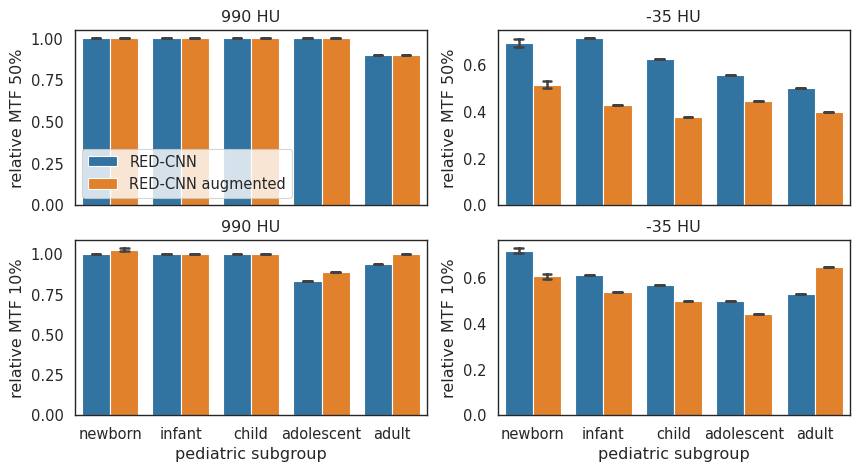

In [84]:
sns.set_context('paper', font_scale=1.2)
sns.set_style('white')
f, axs = plt.subplots(2,2, figsize=(10, 5), sharex=True)
for row, mtf_cutoff in enumerate([50, 10]):
    for col, contrast in enumerate([990, -35]):
        sns.barplot(ax=axs[row, col], data=mtf_df[(mtf_df['Dose [%]']==1000)&(mtf_df['contrast']==contrast)], x='pediatric subgroup', y=f'relative MTF {mtf_cutoff}%', hue='recon', hue_order=['RED-CNN', 'RED-CNN augmented'], order=['newborn', 'infant', 'child', 'adolescent', 'adult'], capsize=0.25)
        axs[row, col].set_title(f'{contrast} HU')
        if (row + col) == 0:
            axs[row, col].legend(loc='lower left')
        else:
            axs[row, col].get_legend().remove()

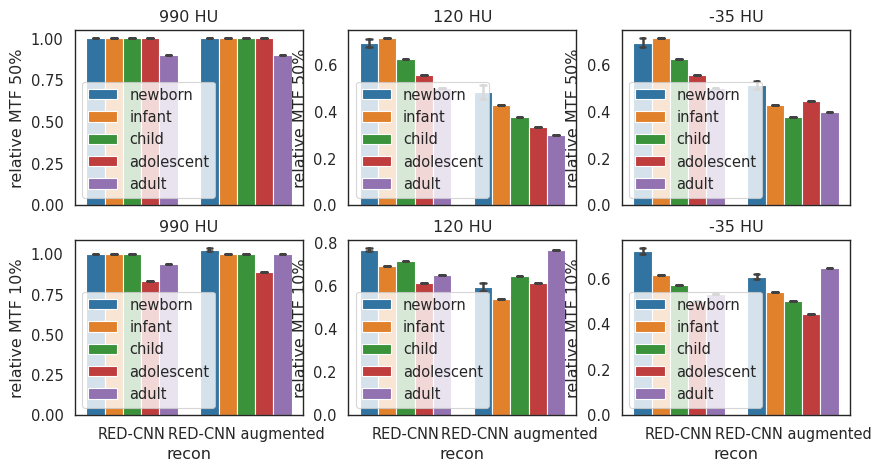

In [77]:
f, axs = plt.subplots(2,3, figsize=(10, 5), sharex=True)

for row, mtf_cutoff in enumerate([50, 10]):
    for col, contrast in enumerate([990, 120, -35]):
        sns.barplot(ax=axs[row, col], data=mtf_df[(mtf_df['Dose [%]']==1000)&(mtf_df['contrast']==contrast)], x='recon', y=f'relative MTF {mtf_cutoff}%', hue='pediatric subgroup', order=['RED-CNN', 'RED-CNN augmented'], hue_order=['newborn', 'infant', 'child', 'adolescent', 'adult'], capsize=0.25)
        axs[row, col].set_title(f'{contrast} HU')
        axs[row, col].legend(loc='lower left')

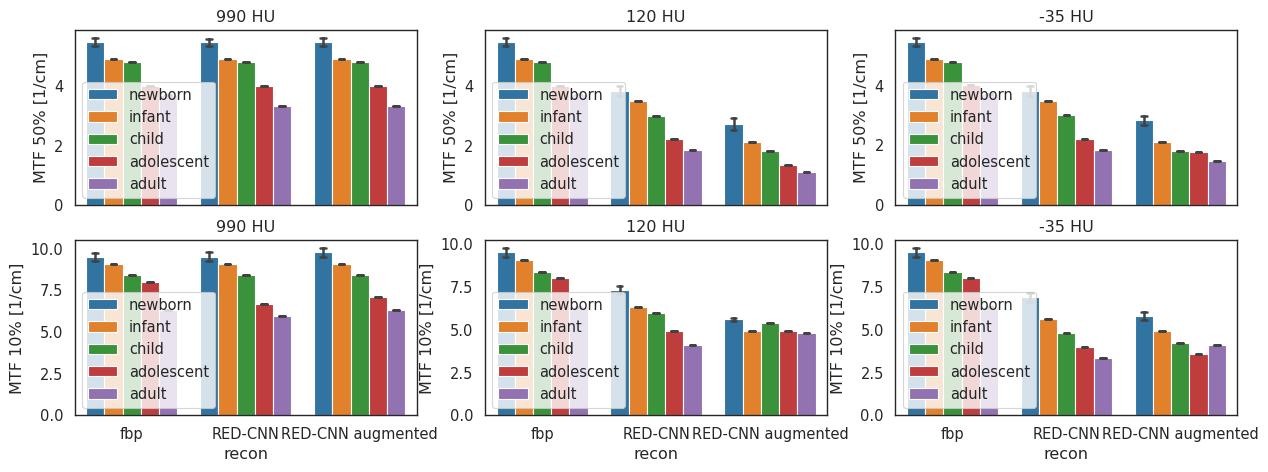

In [78]:
f, axs = plt.subplots(2,3, figsize=(15, 5), sharex=True)

for row, mtf_cutoff in enumerate([50, 10]):
    for col, contrast in enumerate([990, 120, -35]):
        sns.barplot(ax=axs[row, col], data=mtf_df[(mtf_df['Dose [%]']==1000)&(mtf_df['contrast']==contrast)], x='recon', y=f'MTF {mtf_cutoff}% [1/cm]', hue='pediatric subgroup', order=['fbp', 'RED-CNN', 'RED-CNN augmented'], hue_order=['newborn', 'infant', 'child', 'adolescent', 'adult'], capsize=0.25)
        axs[row, col].set_title(f'{contrast} HU')
        axs[row, col].legend(loc='lower left')

Could show with either recon or subgroup on x but I think subgroup makes more sense as its easier to visualize changes

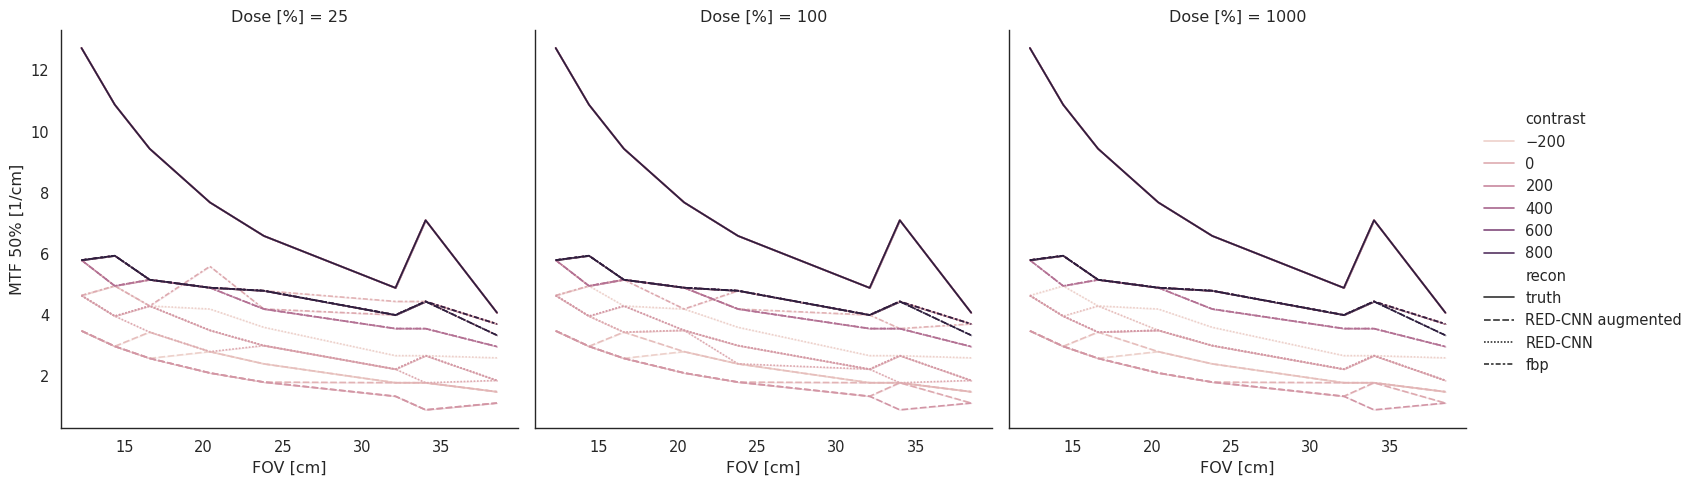

In [79]:
sns.relplot(data=mtf_df[(mtf_df['Dose [%]'].isin([25, 100, 1000]))], x='FOV [cm]', y='MTF 50% [1/cm]', hue='contrast', style='recon', col='Dose [%]', kind='line')

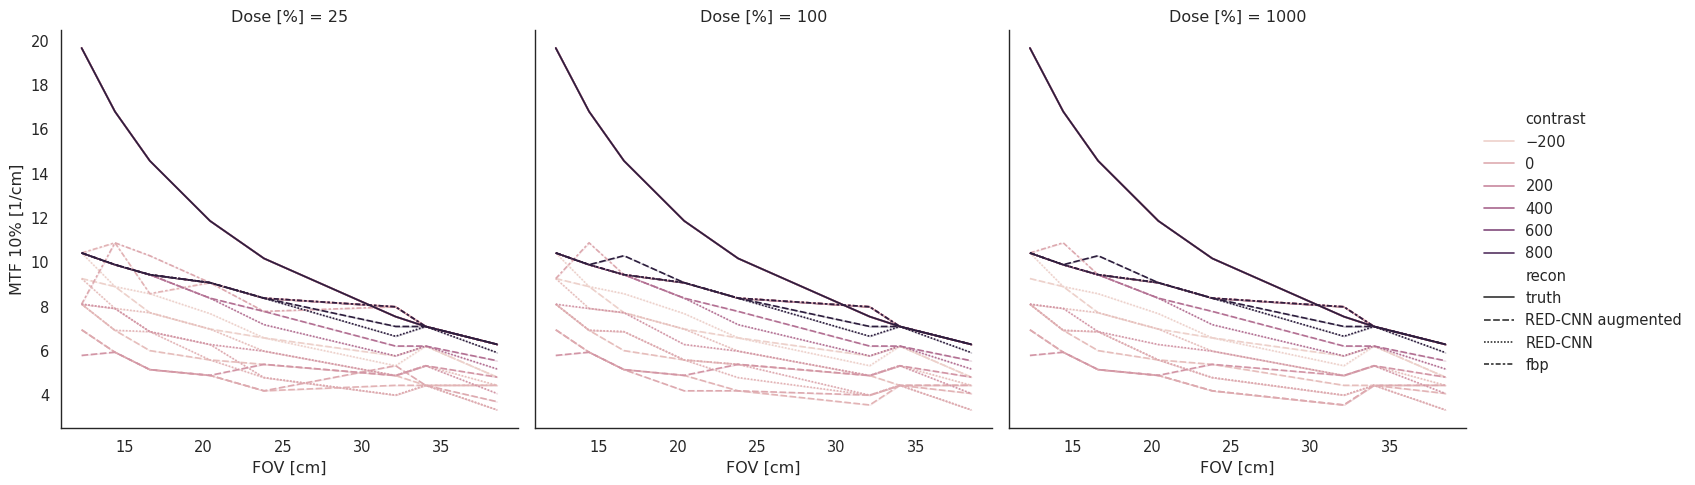

In [80]:
sns.relplot(data=mtf_df[(mtf_df['Dose [%]'].isin([25, 100, 1000]))], x='FOV [cm]', y='MTF 10% [1/cm]', hue='contrast', style='recon', col='Dose [%]', kind='line')

In [81]:
mtf_df.to_csv('mtf.csv', index=False)

In [82]:
mtf_df[(mtf_df['spatial frequency [1/cm]']==0)&(mtf_df['contrast']==-200)&(mtf_df['Dose [%]']==1000)&(mtf_df['spatial frequency [1/cm]']==0)&(mtf_df['recon']!='truth')][['name', 'MTF 10% [1/cm]', 'MTF 50% [1/cm]']]

name MTF 10% [1/cm]  \
1134   35.0 cm 1000% dose RED-CNN augmented -200 HU       4.802309   
1260             35.0 cm 1000% dose RED-CNN -200 HU       4.802309   
1386                 35.0 cm 1000% dose fbp -200 HU       6.279942   
4599   15.0 cm 1000% dose RED-CNN augmented -200 HU       6.200692   
4662             15.0 cm 1000% dose RED-CNN -200 HU       6.200692   
4725                 15.0 cm 1000% dose fbp -200 HU       7.086505   
7182   11.2 cm 1000% dose RED-CNN augmented -200 HU       9.250226   
7308             11.2 cm 1000% dose RED-CNN -200 HU      10.406504   
7434                 11.2 cm 1000% dose fbp -200 HU      10.406504   
11214  18.5 cm 1000% dose RED-CNN augmented -200 HU       6.971678   
11340            18.5 cm 1000% dose RED-CNN -200 HU       7.668845   
11466                18.5 cm 1000% dose fbp -200 HU       9.063181   
15246  21.6 cm 1000% dose RED-CNN augmented -200 HU       6.573296   
15372            21.6 cm 1000% dose RED-CNN -200 HU       6.573296   
15498                21.6 cm 1000% dose fbp -200 HU       8.366013   
19278  13.1 cm 1000% dose RED-CNN augmented -200 HU       8.888889   
19404            13.1 cm 1000% dose RED-CNN -200 HU       8.888889   
19530                13.1 cm 1000% dose fbp -200 HU       9.876543   
23373  29.2 cm 1000% dose RED-CNN augmented -200 HU       5.759778   
23506            29.2 cm 1000% dose RED-CNN -200 HU       5.316719   
23639                29.2 cm 1000% dose fbp -200 HU       7.975078   
27566  15.1 cm 1000% dose RED-CNN augmented -200 HU       7.710843   
27692            15.1 cm 1000% dose RED-CNN -200 HU       8.567604   
27818                15.1 cm 1000% dose fbp -200 HU       9.424364   

      MTF 50% [1/cm]  
1134        1.477633  
1260        2.585859  
1386        3.694084  
4599        1.771626  
4662        2.657439  
4725        4.429066  
7182        3.468835  
7308        4.625113  
7434        5.781391  
11214       2.788671  
11340       4.183007  
11466       4.880174  
15246       2.390289  
15372       3.585434  
15498       4.780579  
19278       2.962963  
19404       4.938272  
19530       5.925926  
23373        1.77224  
23506       2.658359  
23639       3.987539  
27566       2.570281  
27692       4.283802  
27818       5.140562